In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

1)      Relative FL

2)      Breakdown by diversity, plot each # of strains together (color by # of strains)

3)      Box plots: growth rate, decline rate, FL @ 40 and 60 days – by diversity, by strain

4)      PCA 3 dimension

5)      What combinations are clustered non-randomly (e.g. PCA, tSNE)

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [182]:
MIT0604_color = '#f79934'
MIT9312_color = '#face6e'
MED4_color = '#62A586'
Natl2A_color = '#7A9BC8'
MIT9313_color = '#F47681'
SYN_color = '#6cf0ba'
syn_0606_color = '#d13f75'
syn_natl_color = '#eeb7cb'
syn_natl_0604_color = '#b9d2d8'
other_color = 'lightgrey'
syn_natl_color = '#4ec4cf' #'#54a4ba' # '#6cf0e1'
syn_0606_color = '#dffc03' #'#8df06c'
natl_0604_color = '#70d156' #'#2e6e54'
syn_natl_0604_color = '#2e6e54'
SYN_color = '#6cf0ba'
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', SYN_color]


color_dict = {
'MIT0604' : '#f79934',
'MIT9312' : '#face6e',
'MED4' : '#62A586',
'NATL2A' :  '#7A9BC8',
'MIT9313' : '#F47681',
'Syn WH8102' : '#6cf0ba',
}

In [7]:
species = ['MIT0604', 'MIT9312', 'MED4', 'NATL2A', 'MIT9313', 'Syn WH8102']

In [8]:
os.listdir('6x6')

['fl_exp1.csv', '6x6_setup.csv', 'fl_exp2.csv', 'fl_exp3.csv']

In [9]:
setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'Total tubes', 'how many in 1 tube ?']
use_setup_columns = ['Sample', 'MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102']

setup_df = pd.read_csv(os.path.join('6x6', '6x6_setup.csv'), names=setup_columns, usecols=use_setup_columns)

In [10]:
setup_df.dropna(axis=0, subset=['Sample'], inplace=True)

In [11]:
for c in setup_df.columns:
    setup_df[c] = pd.to_numeric(setup_df[c], downcast='integer')

In [12]:
setup_df.rename(columns={'9313' : 'MIT9313', '9312':'MIT9312'}, inplace=True)

In [13]:
setup_df.head()

Sample  MED4  MIT9313  MIT9312  NATL2A  MIT0604  Syn WH8102
2       1   1.0      NaN      NaN     NaN      NaN         NaN
3       2   NaN      2.0      NaN     NaN      NaN         NaN
4       3   NaN      NaN      3.0     NaN      NaN         NaN
5       4   NaN      NaN      NaN     4.0      NaN         NaN
6       5   NaN      NaN      NaN     NaN      5.0         NaN

In [14]:
exp1_df = pd.read_csv(os.path.join('6x6', 'fl_exp1.csv'))
exp2_df = pd.read_csv(os.path.join('6x6', 'fl_exp2.csv'))

In [15]:
exp1_df = pd.melt(exp1_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')
exp2_df = pd.melt(exp2_df, id_vars=['Date', 'Day'], value_name='FL', var_name='Sample')

In [16]:
exp1_df.head()

Date       Day Sample     FL
0  6/20/2019 12:19  0.000000     1A  0.172
1  6/21/2019 16:03  1.155556     1A  0.250
2  6/23/2019 13:56  3.067361     1A  0.482
3  6/24/2019 12:22  4.002083     1A  0.703
4   6/25/2019 9:00  4.861806     1A  0.781

In [17]:
exp2_df.head()

Date       Day Sample     FL
0  7/29/2019 14:54  0.000000     1A  0.009
1  7/31/2019 14:54  2.000000     1A  0.019
2   8/1/2019 12:28  2.898611     1A -0.019
3   8/4/2019 16:32  6.068056     1A  0.028
4   8/6/2019 13:10  7.927778     1A  0.009

In [18]:
exp1_df['sample_prefix'] = pd.to_numeric(exp1_df.Sample.str.rstrip('[ABCDEFGH]'))
exp2_df['sample_prefix'] = pd.to_numeric(exp2_df.Sample.str.rstrip('[ABCDEFGH]'))

In [19]:
exp1_df['experiment'] = 'e1'
exp2_df['experiment'] = 'e2'

In [20]:
setup_df.index = setup_df.Sample

In [21]:
tmp_df = setup_df.drop(columns=['Sample']).notna()

In [22]:
tmp_df['num_of_species'] = tmp_df.sum(axis=1)

In [23]:
tmp_df['ssp'] = pd.melt(setup_df, id_vars=['Sample']).dropna().groupby('Sample')['variable'].unique().str.join(',')

In [24]:
exp1_df = pd.merge(exp1_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)
exp2_df = pd.merge(exp2_df, tmp_df, how='left', left_on='sample_prefix', right_index=True)

In [25]:
exp1_df.loc[exp1_df['FL']< 0.05,'FL'] = 0.05
exp2_df.loc[exp2_df['FL']< 0.05,'FL'] = 0.05

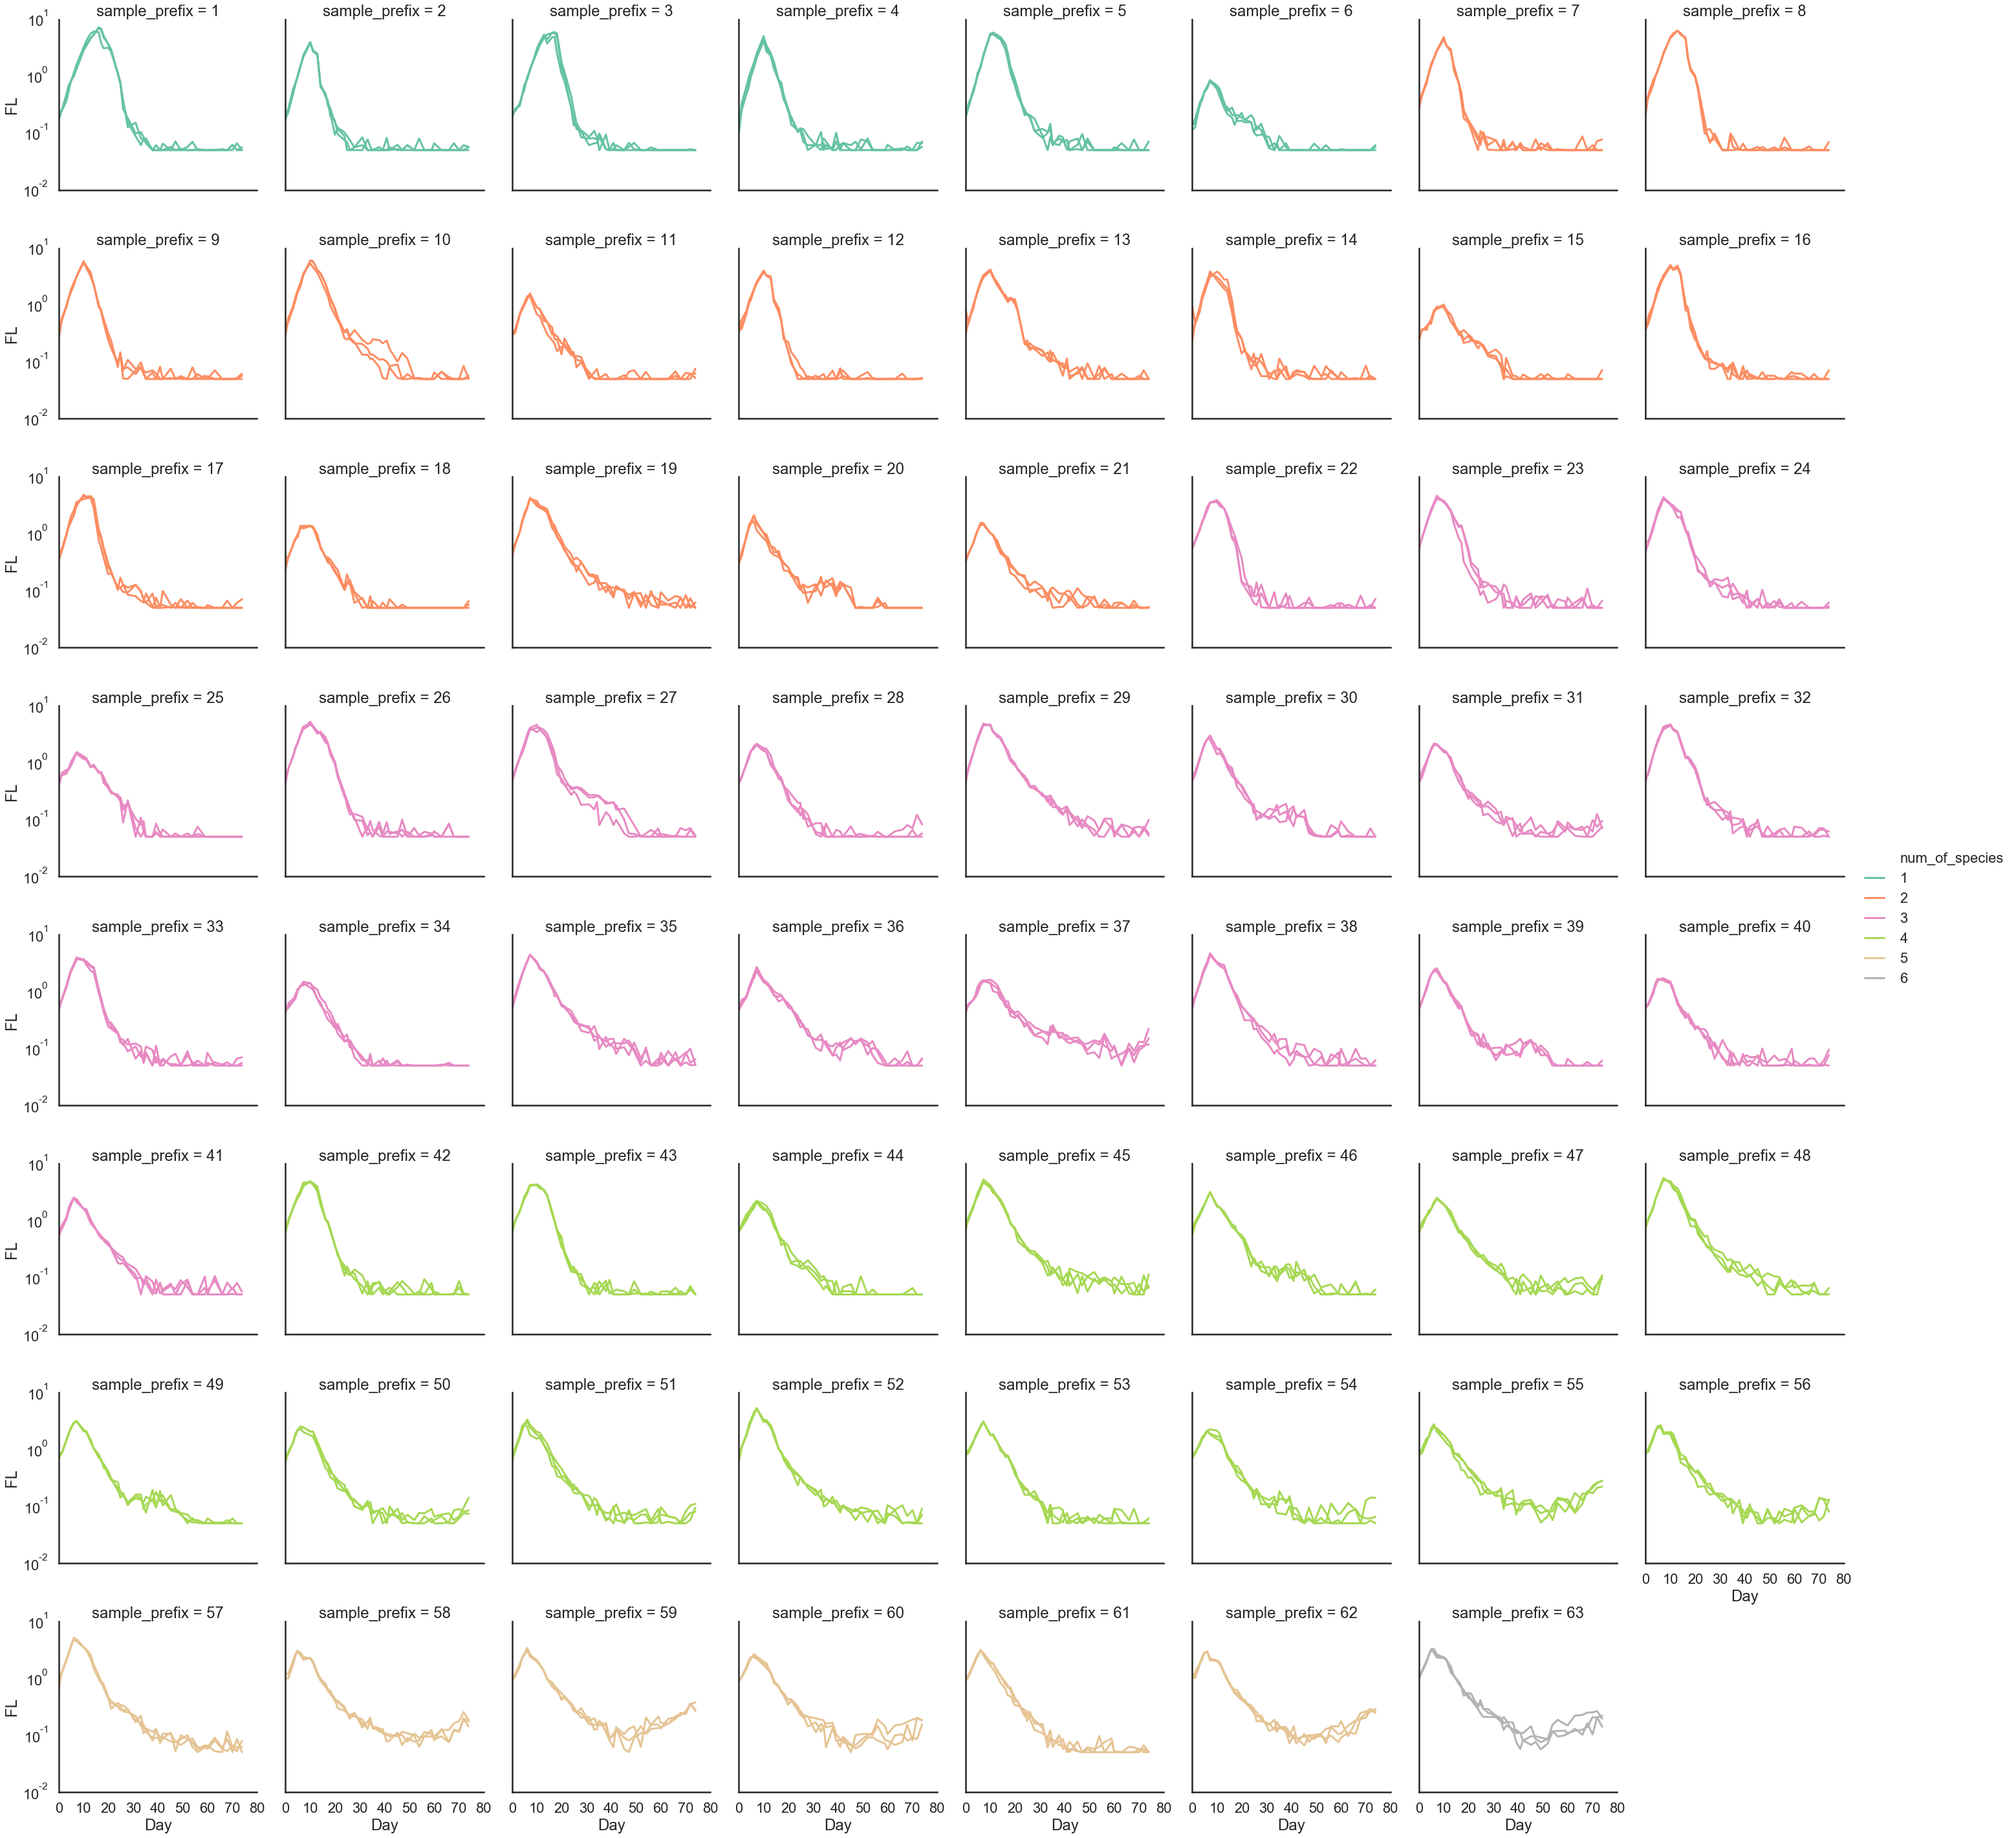

In [26]:
g = sns.relplot(data=exp1_df, x='Day', y='FL', col='sample_prefix', col_wrap=8, kind='line', #ci='sd',
                            estimator=None, units='Sample',

                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

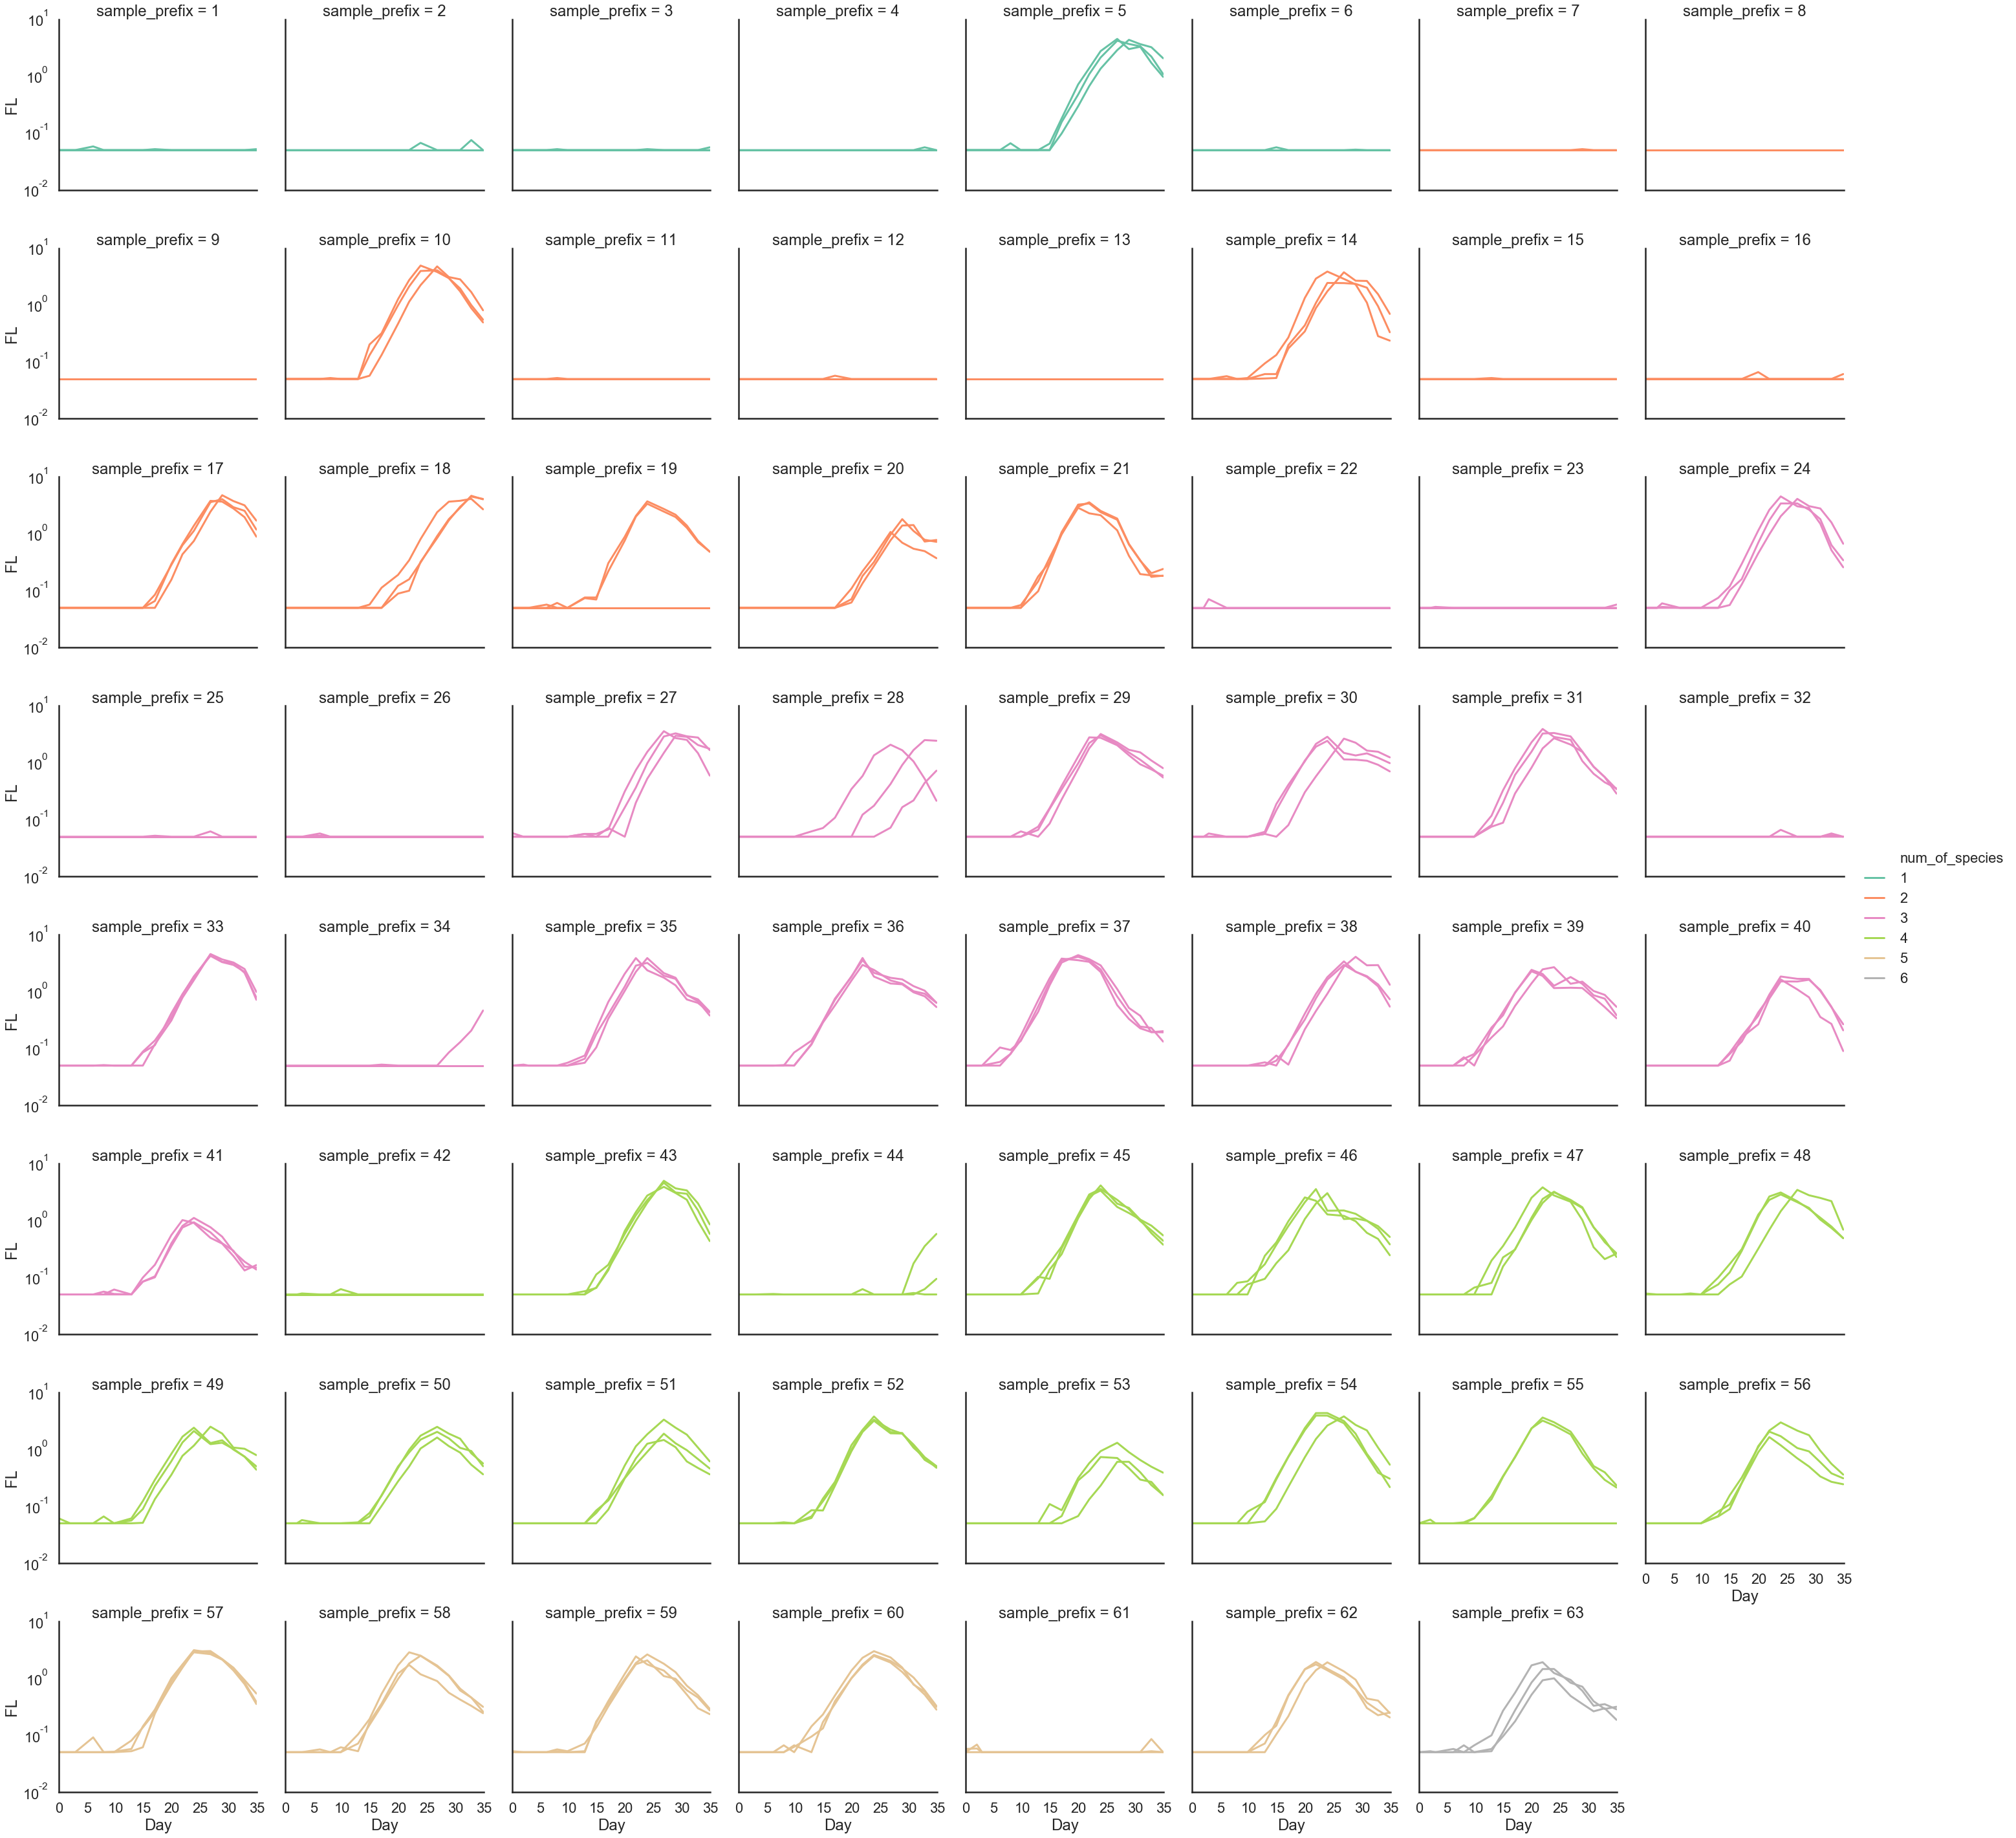

In [27]:
g = sns.relplot(data=exp2_df, x='Day', y='FL', col='sample_prefix', col_wrap=8, kind='line', #ci='sd', 
                            estimator=None, units='Sample',

                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

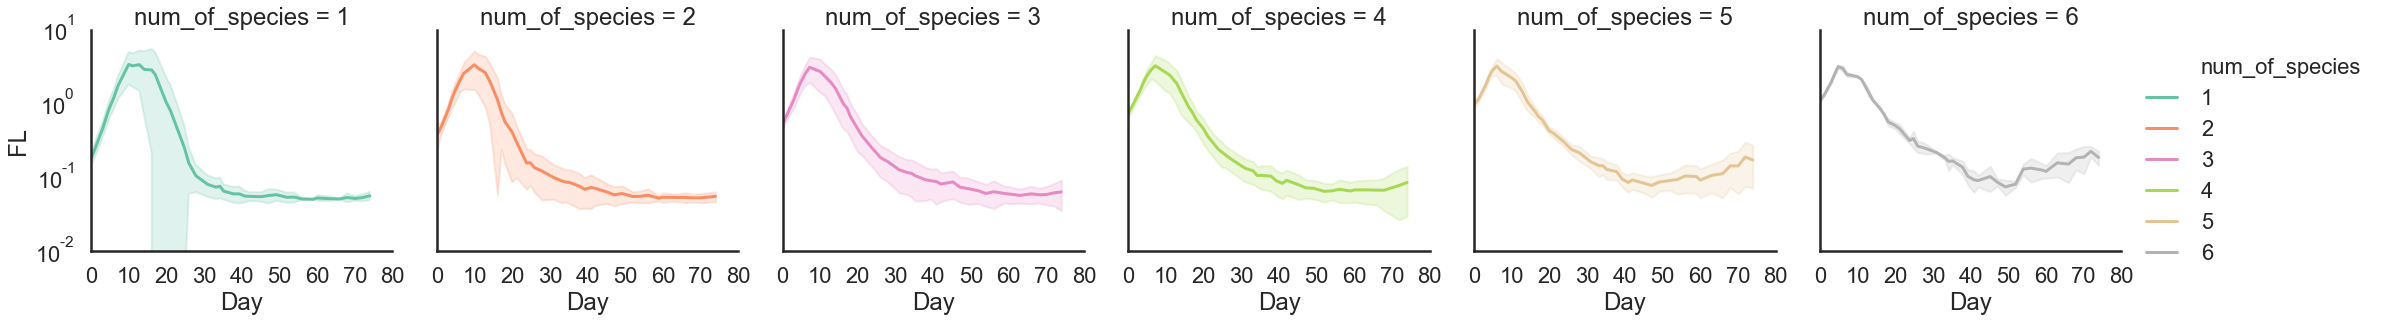

In [28]:
g = sns.relplot(data=exp1_df, x='Day', y='FL', col='num_of_species', kind='line', ci='sd',
                hue='num_of_species', palette='Set2', legend='full')
               
g.set(yscale='log')

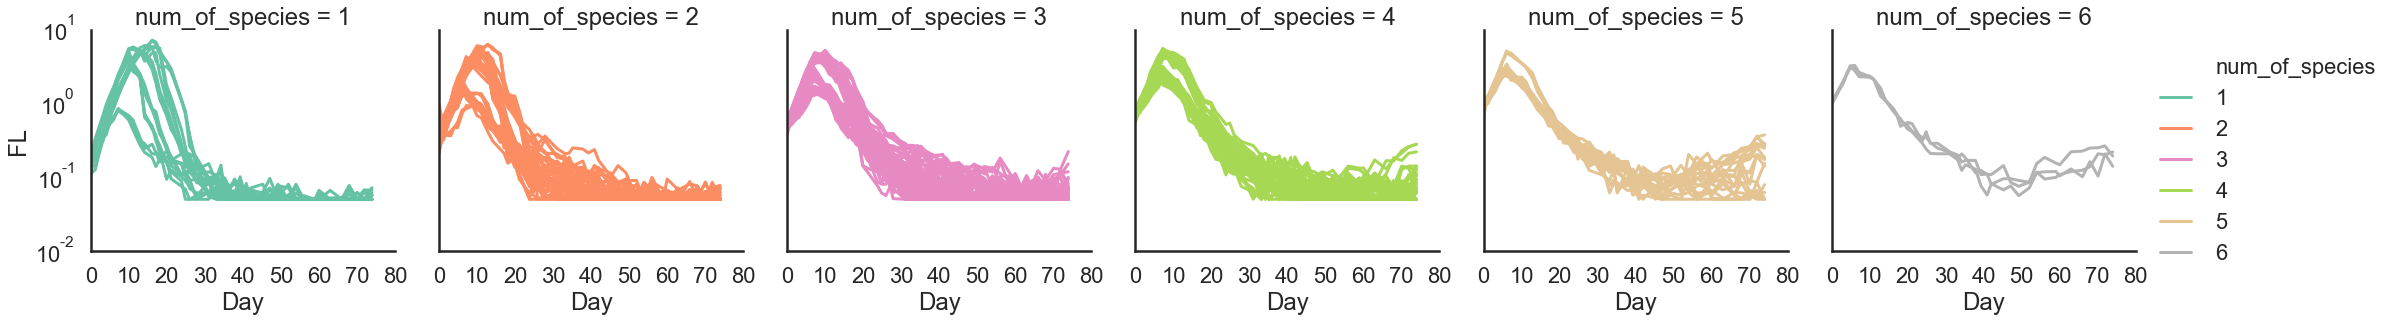

In [29]:
g = sns.relplot(data=exp1_df, x='Day', y='FL', col='num_of_species', kind='line', #ci='sd',
                            estimator=None, units='Sample',
                hue='num_of_species', palette='Set2', legend='full')
               
g.set(yscale='log')

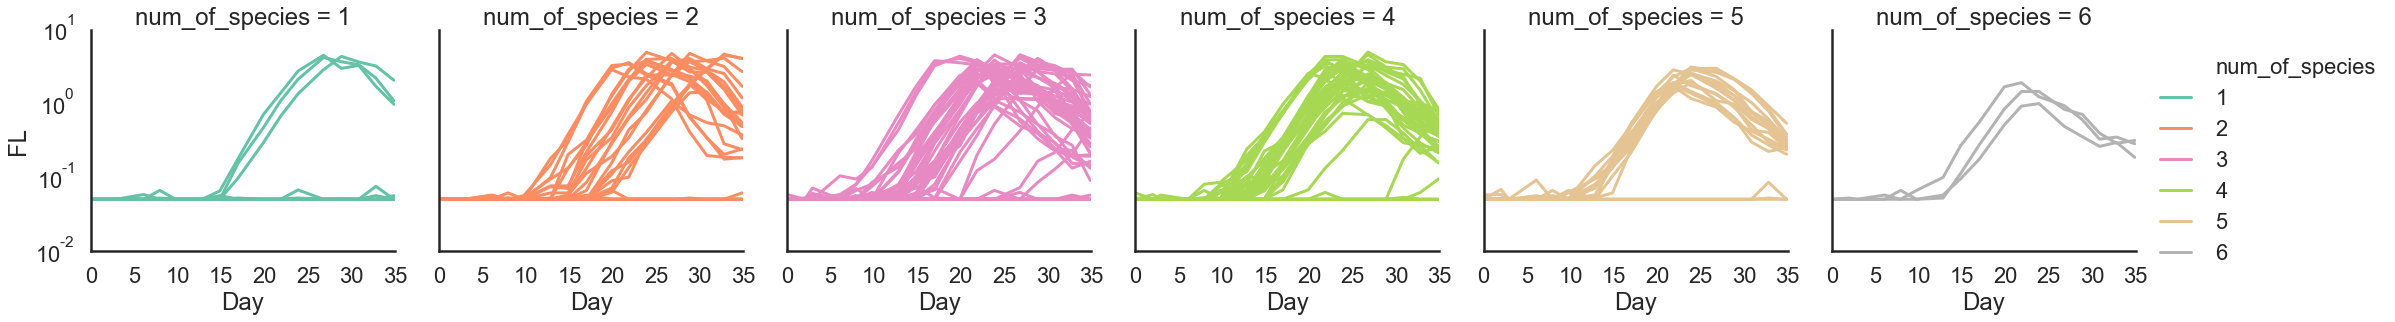

In [30]:
g = sns.relplot(data=exp2_df, x='Day', y='FL', col='num_of_species', kind='line', 
               # ci='sd'
            estimator=None, units='Sample',
                hue='num_of_species', palette='Set2', legend='full')
g.set(yscale='log')

In [31]:
exp1_df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp'],
      dtype='object')

In [32]:
exp1_dfm = pd.melt(exp1_df, id_vars=['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'num_of_species'],
       var_name='sp', value_vars=species)
exp2_dfm = pd.melt(exp2_df, id_vars=['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'num_of_species'],
       var_name='sp', value_vars=species)

In [33]:
exp1_dfm.sp.value_counts()

MIT9312       7938
NATL2A        7938
MIT0604       7938
MIT9313       7938
Syn WH8102    7938
MED4          7938
Name: sp, dtype: int64

In [34]:
exp1_dfm['value'].value_counts()

True     24192
False    23436
Name: value, dtype: int64

In [35]:
exp1_dfm = exp1_dfm.loc[exp1_dfm['value']]
exp2_dfm = exp2_dfm.loc[exp2_dfm['value']]
exp1_dfm.drop(columns=['value'], inplace=True)
exp2_dfm.drop(columns=['value'], inplace=True)

In [36]:
exp1_dfm.sp.value_counts()

MIT9312       4032
Syn WH8102    4032
NATL2A        4032
MIT0604       4032
MED4          4032
MIT9313       4032
Name: sp, dtype: int64

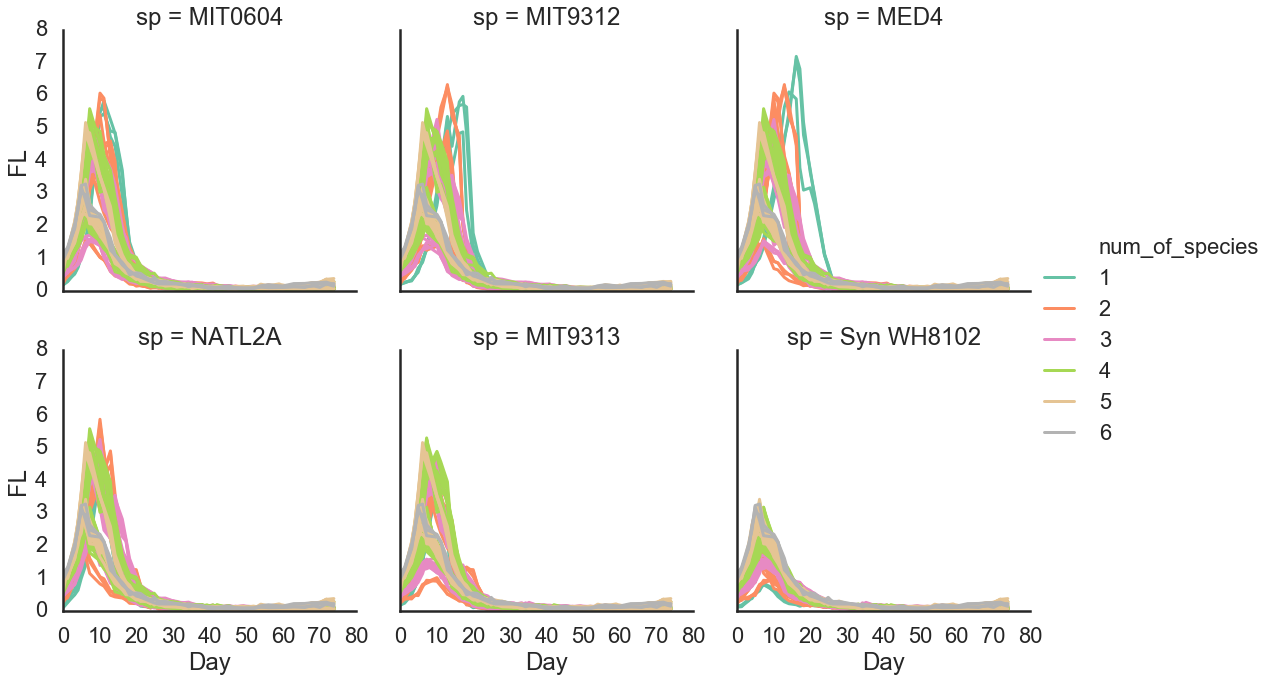

In [37]:
sns.relplot(data=exp1_dfm, x='Day', y='FL', kind='line', #ci='sd',
            estimator=None, units='Sample',
            col='sp', col_wrap=3, #aspect=2,
                hue='num_of_species', palette='Set2', legend='full'
               )
g.set(yscale='log')

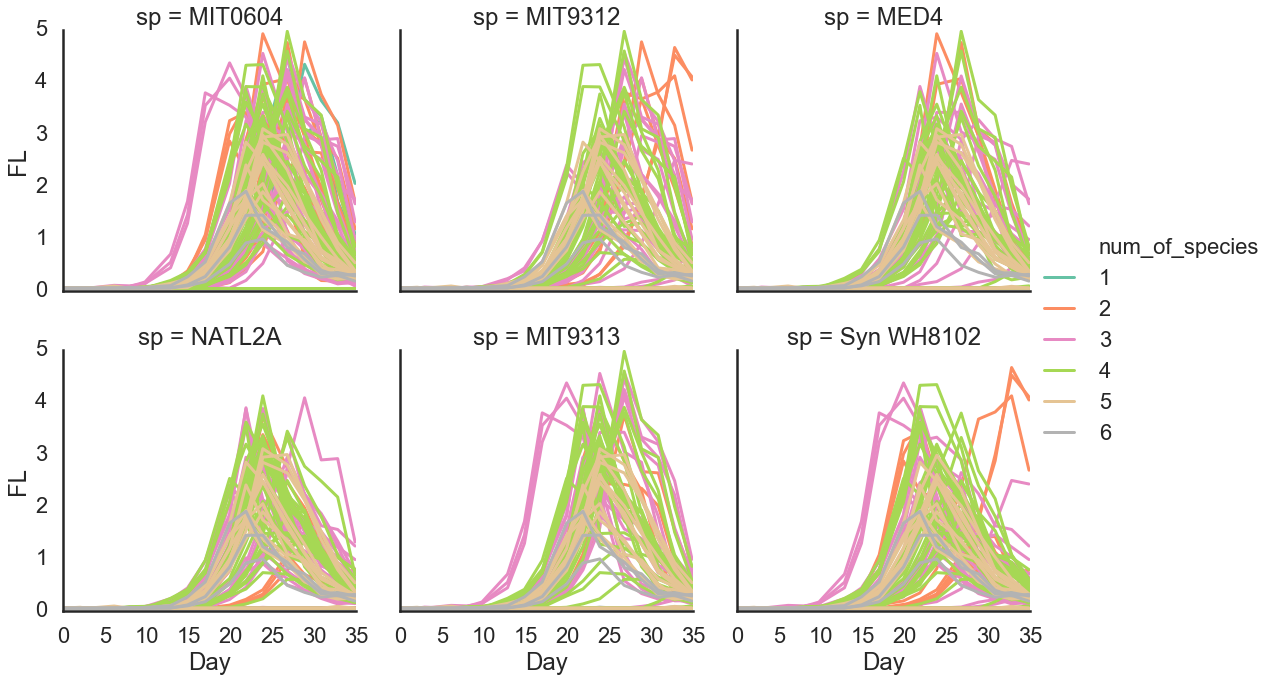

In [38]:
sns.relplot(data=exp2_dfm, x='Day', y='FL', kind='line', #ci='sd',
            estimator=None, units='Sample',
            col='sp', col_wrap=3,
                hue='num_of_species', palette='Set2', legend='full'
               )
g.set(yscale='log')

In [39]:
df = pd.concat([exp1_df, exp2_df])

In [40]:
df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp'],
      dtype='object')

# Features Analysis

3)      Box plots: growth rate, decline rate, FL @ 40 and 60 days – by diversity, by strain

In [41]:
exp1_df.Day.value_counts().sort_index()

0.000000     189
1.155556     189
3.067361     189
4.002083     189
4.861806     189
6.057639     189
7.172917     189
9.990972     189
11.078472    189
12.854167    189
14.123611    189
16.106250    189
17.098611    189
18.095833    189
19.906944    189
21.093056    189
23.827083    189
24.829167    189
25.956250    189
27.844444    189
31.017361    189
33.154861    189
34.213889    189
35.182639    189
37.843056    189
39.272917    189
40.888194    189
41.988194    189
45.218056    189
47.090972    189
49.215972    189
51.955556    189
53.965972    189
56.041667    189
58.974306    189
60.025000    189
62.982639    189
65.981944    189
67.979167    189
70.099306    189
71.909028    189
73.969444    189
Name: Day, dtype: int64

In [42]:
day40 = 40.88819444
day60 = 60.025000

In [75]:
day40 = exp1_df.loc[(exp1_df.Day <41) & (exp1_df.Day >40)].Day.max()

In [76]:
def find_growth_rate(df, min_day, max_day):
    fit = cp.apply_fit(
        df.loc[(df.Day <= max_day) & (df.Day >= min_day)], 
        model=cp.model_exponential, x_col='Day', print_popt=False
    )
    return fit.popt_0.min()

In [77]:
def find_decline_rate(df, min_day, max_day):
    fit = cp.apply_fit(
        df.loc[(df.Day <= max_day) & (df.Day >= min_day)], 
        model=cp.model_exponential_decline, x_col='Day', print_popt=False
    )
    return fit.popt_0.min()

In [78]:
exp1_df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp'],
      dtype='object')

In [79]:
from sklearn.metrics import auc
def _analyze_curve(df, day40=day40, day60=day60, day_col='Day', fl_col='FL'):
    fl_max = df[fl_col].max()
    day_max = df.loc[df[fl_col] == fl_max, day_col].min()
    fl_40 = df.loc[df[day_col] == day40, fl_col].min()
    fl_60 = df.loc[df[day_col] == day60, fl_col].min()
    auc_val = auc(x=df[day_col], y=df[fl_col])
    growth_rate = find_growth_rate(df, 0, day_max)
    decline_rate = find_decline_rate(df, day_max, 10000)

    return pd.Series({
        'max FL': fl_max, 
        'max Day': day_max, 
        'FL @40 days' : fl_40,
        'FL @60 days' : fl_60,
        'auc': auc_val,
        'growth rate': growth_rate,
        'decline rate' : decline_rate,
    })
    
    

In [80]:
exp1_dfg = exp1_df.groupby(['Sample', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp']).apply(_analyze_curve)

In [81]:
exp1_dfg.head()

max FL  \
Sample sample_prefix experiment MED4 MIT9313 MIT9312 NATL2A MIT0604 Syn WH8102 num_of_species ssp                       
10A    10            e1         True False   False   False  True    False      2              MED4,MIT0604      5.914   
10B    10            e1         True False   False   False  True    False      2              MED4,MIT0604      6.056   
10C    10            e1         True False   False   False  True    False      2              MED4,MIT0604      5.394   
11A    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102   1.429   
11B    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102   1.540   

                                                                                                                max Day  \
Sample sample_prefix experiment MED4 MIT9313 MIT9312 NATL2A MIT0604 Syn WH8102 num_of_species ssp                         
10A    10            e1         True False   False   False  True    False      2              MED4,MIT0604     9.990972   
10B    10            e1         True False   False   False  True    False      2              MED4,MIT0604     9.990972   
10C    10            e1         True False   False   False  True    False      2              MED4,MIT0604     9.990972   
11A    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102  6.057639   
11B    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102  7.172917   

                                                                                                               FL @40 days  \
Sample sample_prefix experiment MED4 MIT9313 MIT9312 NATL2A MIT0604 Syn WH8102 num_of_species ssp                            
10A    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.050   
10B    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.101   
10C    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.236   
11A    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102        0.050   
11B    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102        0.050   

                                                                                                               FL @60 days  \
Sample sample_prefix experiment MED4 MIT9313 MIT9312 NATL2A MIT0604 Syn WH8102 num_of_species ssp                            
10A    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.050   
10B    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.065   
10C    10            e1         True False   False   False  True    False      2              MED4,MIT0604           0.050   
11A    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102        0.050   
11B    11            e1         True False   False   False  False   True       2              MED4,Syn WH8102        0.050   

                                                                                                                     auc  \
Sample sample_prefix experiment MED4 MIT9313 MIT9312 NATL2A MIT0604 Syn WH8102 num_of_species ssp                          
10A    10            e1         True False   False   False  True    False      2              MED4,MIT0604     61.149530   
10B    10            e1         True False   False   False  True    False      2              MED4,MIT0604     61.719644   
10C    10            e1         True False   False   False  True    False      2              MED4,MIT0604     57.282098   
11A    11      

In [82]:
exp1_dfg.reset_index(inplace=True)

In [83]:
from sklearn.metrics import auc
def _analyze_curve_exp2(df, day40=day40, day60=day60, day_col='Day', fl_col='FL'):
    fl_max = df[fl_col].max()
    day_max = df.loc[df[fl_col] == fl_max, day_col].min()
    #fl_40 = df.loc[df[day_col] == day40, fl_col].min()
    #fl_60 = df.loc[df[day_col] == day60, fl_col].min()
    auc_val = auc(x=df[day_col], y=df[fl_col])
    #growth_rate = find_growth_rate(df, 0, day_max)
    #decline_rate = find_decline_rate(df, day_max, 10000)

    return pd.Series({
        'max FL': fl_max, 
        'max Day': day_max, 
        #'FL @40 days' : fl_40,
        #'FL @60 days' : fl_60,
        'auc': auc_val,
        #'growth rate': growth_rate,
        #'decline rate' : decline_rate,
    })
    
    

In [84]:
exp2_dfg = exp2_df.groupby(['Sample', 'sample_prefix', 'experiment', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102',
       'num_of_species', 'ssp']).apply(_analyze_curve_exp2)

In [85]:
exp2_dfg.reset_index(inplace=True)

In [86]:
exp2_dfg.head()

Sample  sample_prefix experiment  MED4  MIT9313  MIT9312  NATL2A  MIT0604  \
0    10A             10         e2  True    False    False   False     True   
1    10B             10         e2  True    False    False   False     True   
2    10C             10         e2  True    False    False   False     True   
3    11A             11         e2  True    False    False   False    False   
4    11B             11         e2  True    False    False   False    False   

   Syn WH8102  num_of_species              ssp  max FL    max Day        auc  
0       False               2     MED4,MIT0604   4.921  23.858333  43.829473  
1       False               2     MED4,MIT0604   4.063  26.784722  40.675184  
2       False               2     MED4,MIT0604   4.752  26.784722  38.026039  
3        True               2  MED4,Syn WH8102   0.052   7.927778   1.748589  
4        True               2  MED4,Syn WH8102   0.050   0.000000   1.744896

In [87]:
dfg = pd.concat([exp1_dfg, exp2_dfg], sort=False)

In [88]:
dfg.head()

Sample  sample_prefix experiment  MED4  MIT9313  MIT9312  NATL2A  MIT0604  \
0    10A             10         e1  True    False    False   False     True   
1    10B             10         e1  True    False    False   False     True   
2    10C             10         e1  True    False    False   False     True   
3    11A             11         e1  True    False    False   False    False   
4    11B             11         e1  True    False    False   False    False   

   Syn WH8102  num_of_species              ssp  max FL   max Day  FL @40 days  \
0       False               2     MED4,MIT0604   5.914  9.990972        0.050   
1       False               2     MED4,MIT0604   6.056  9.990972        0.101   
2       False               2     MED4,MIT0604   5.394  9.990972        0.236   
3        True               2  MED4,Syn WH8102   1.429  6.057639        0.050   
4        True               2  MED4,Syn WH8102   1.540  7.172917        0.050   

   FL @60 days        auc  growth rate  decline rate  
0        0.050  61.149530     0.189704      0.043518  
1        0.065  61.719644     0.193129      0.040749  
2        0.050  57.282098     0.181697      0.035747  
3        0.050  16.091496     0.126755      0.084749  
4        0.050  17.595684     0.115697      0.072173

In [89]:
dfg.tail()

Sample  sample_prefix experiment  MED4  MIT9313  MIT9312  NATL2A  MIT0604  \
184     8B              8         e2  True    False     True   False    False   
185     8C              8         e2  True    False     True   False    False   
186     9A              9         e2  True    False    False    True    False   
187     9B              9         e2  True    False    False    True    False   
188     9C              9         e2  True    False    False    True    False   

     Syn WH8102  num_of_species           ssp  max FL  max Day  FL @40 days  \
184       False               2  MED4,MIT9312    0.05      0.0          NaN   
185       False               2  MED4,MIT9312    0.05      0.0          NaN   
186       False               2   MED4,NATL2A    0.05      0.0          NaN   
187       False               2   MED4,NATL2A    0.05      0.0          NaN   
188       False               2   MED4,NATL2A    0.05      0.0          NaN   

     FL @60 days       auc  growth rate  decline rate  
184          NaN  1.744896          NaN           NaN  
185          NaN  1.744896          NaN           NaN  
186          NaN  1.744896          NaN           NaN  
187          NaN  1.744896          NaN           NaN  
188          NaN  1.744896          NaN           NaN

In [90]:
dfg.columns

Index(['Sample', 'sample_prefix', 'experiment', 'MED4', 'MIT9313', 'MIT9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate'],
      dtype='object')

In [91]:
dfg.reset_index(inplace=True, drop=True)

In [95]:
pp = dfg.pivot_table(columns=['experiment'], values=['max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate'], index=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
pp.columns = [' '.join(col).strip() for col in pp.columns.values]
pp.reset_index(inplace=True)
pp['diff max FL'] = pp['max FL e2'] - pp['max FL e1']
pp.head()


Sample  sample_prefix  MED4  MIT9313  MIT9312  NATL2A  MIT0604  Syn WH8102  \
0    10A             10  True    False    False   False     True       False   
1    10B             10  True    False    False   False     True       False   
2    10C             10  True    False    False   False     True       False   
3    11A             11  True    False    False   False    False        True   
4    11B             11  True    False    False   False    False        True   

   num_of_species              ssp  ...  FL @60 days e1     auc e1     auc e2  \
0               2     MED4,MIT0604  ...           0.050  61.149530  43.829473   
1               2     MED4,MIT0604  ...           0.065  61.719644  40.675184   
2               2     MED4,MIT0604  ...           0.050  57.282098  38.026039   
3               2  MED4,Syn WH8102  ...           0.050  16.091496   1.748589   
4               2  MED4,Syn WH8102  ...           0.050  17.595684   1.744896   

   decline rate e1  growth rate e1  max Day e1  max Day e2  max FL e1  \
0         0.043518        0.189704    9.990972   23.858333      5.914   
1         0.040749        0.193129    9.990972   26.784722      6.056   
2         0.035747        0.181697    9.990972   26.784722      5.394   
3         0.084749        0.126755    6.057639    7.927778      1.429   
4         0.072173        0.115697    7.172917    0.000000      1.540   

   max FL e2  diff max FL  
0      4.921       -0.993  
1      4.063       -1.993  
2      4.752       -0.642  
3      0.052       -1.377  
4      0.050       -1.490  

[5 rows x 21 columns]

In [96]:
pp.columns

Index(['Sample', 'sample_prefix', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A',
       'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL @40 days e1',
       'FL @60 days e1', 'auc e1', 'auc e2', 'decline rate e1',
       'growth rate e1', 'max Day e1', 'max Day e2', 'max FL e1', 'max FL e2',
       'diff max FL'],
      dtype='object')

In [97]:
pp.sort_values(by='diff max FL').head()

Sample  sample_prefix  MED4  MIT9313  MIT9312  NATL2A  MIT0604  \
32      1C              1  True    False    False   False    False   
31      1B              1  True    False    False   False    False   
185     8C              8  True    False     True   False    False   
183     8A              8  True    False     True   False    False   
184     8B              8  True    False     True   False    False   

     Syn WH8102  num_of_species           ssp  ...  FL @60 days e1     auc e1  \
32        False               1          MED4  ...            0.05  75.623882   
31        False               1          MED4  ...            0.05  73.578203   
185       False               2  MED4,MIT9312  ...            0.05  62.894912   
183       False               2  MED4,MIT9312  ...            0.05  62.770246   
184       False               2  MED4,MIT9312  ...            0.05  63.951243   

       auc e2  decline rate e1  growth rate e1  max Day e1  max Day e2  \
32   1.770050         0.040235        0.130908   16.106250    6.068056   
31   1.746978         0.042382        0.132137   16.106250   34.897917   
185  1.744896         0.052513        0.159669   12.854167    0.000000   
183  1.744896         0.053910        0.158588   12.854167    0.000000   
184  1.744896         0.052538        0.162945   12.854167    0.000000   

     max FL e1  max FL e2  diff max FL  
32       7.180      0.058       -7.122  
31       7.088      0.052       -7.036  
185      6.317      0.050       -6.267  
183      6.256      0.050       -6.206  
184      6.222      0.050       -6.172  

[5 rows x 21 columns]

In [122]:
df.columns

Index(['Date', 'Day', 'Sample', 'FL', 'sample_prefix', 'experiment', 'MED4',
       '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species'],
      dtype='object')

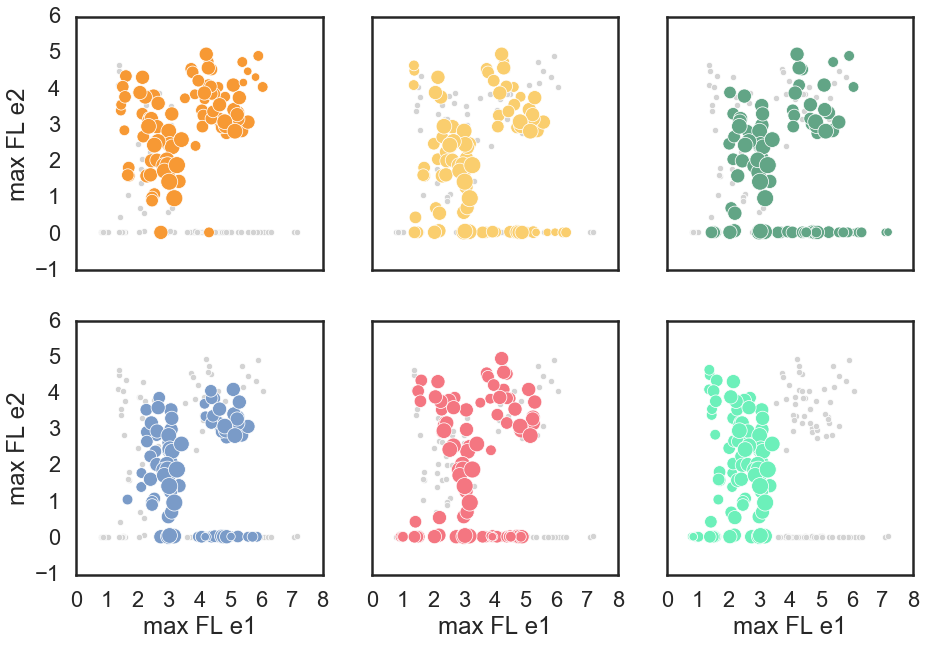

In [103]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp, x='max FL e1', y='max FL e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i]], s=50, 
                x='max FL e1', y='max FL e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

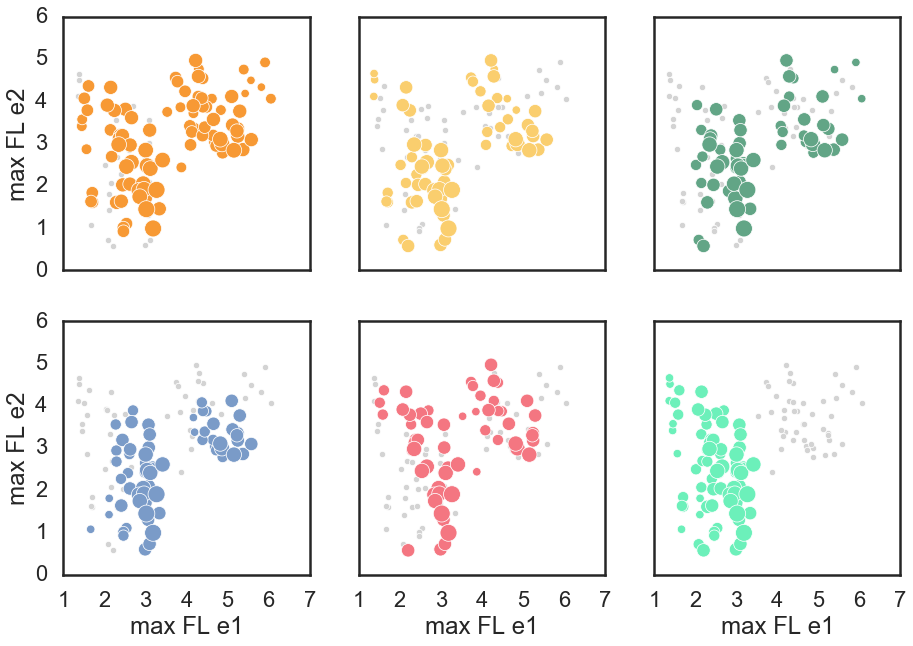

In [106]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp.loc[pp['max FL e2']> 0.5], x='max FL e1', y='max FL e2', s=40, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i] & (pp['max FL e2']> 0.5)], s=50, 
                x='max FL e1', y='max FL e2', size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

In [119]:
pp.columns

Index(['Sample', 'sample_prefix', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A',
       'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL @40 days e1',
       'FL @60 days e1', 'auc e1', 'auc e2', 'decline rate e1',
       'growth rate e1', 'max Day e1', 'max Day e2', 'max FL e1', 'max FL e2',
       'diff max FL'],
      dtype='object')

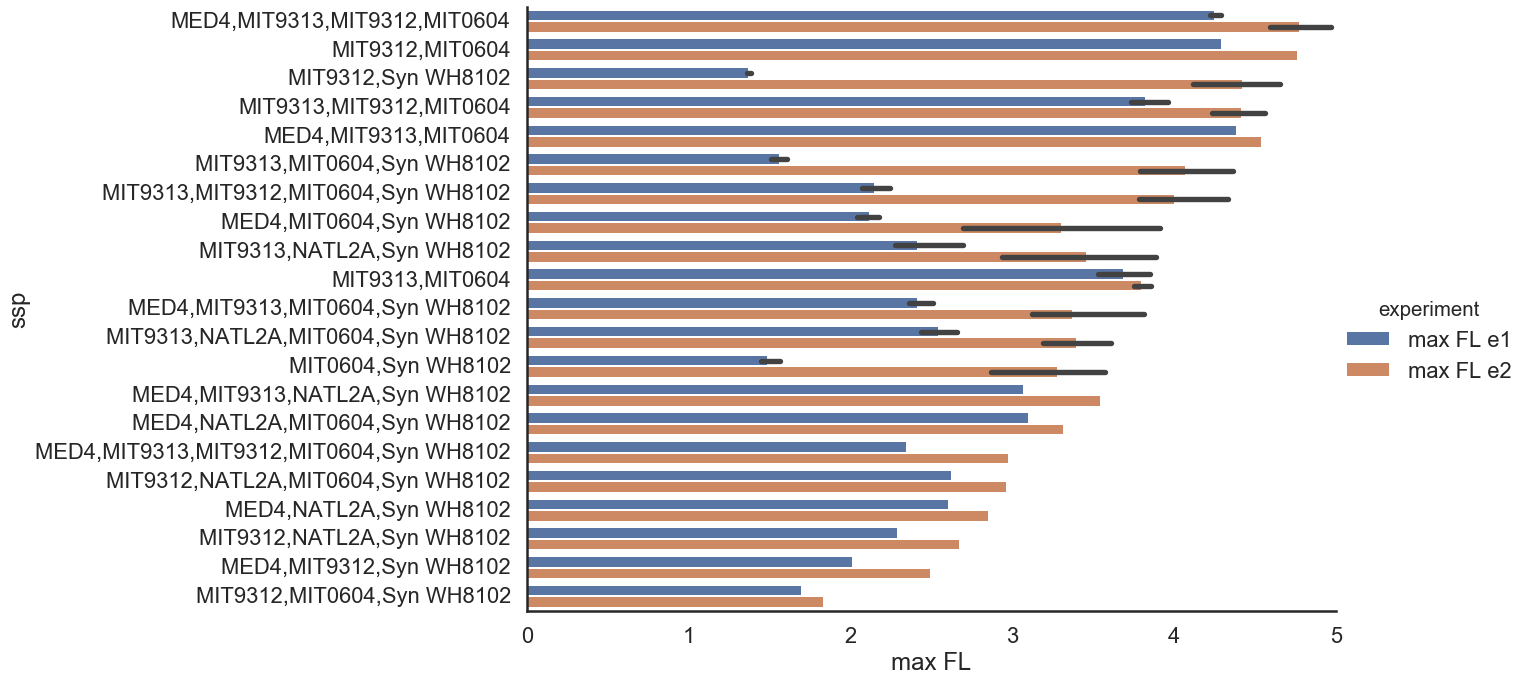

In [127]:
nl_df = pp.loc[pp['diff max FL']>0]
nl_df.head()
nl_df = nl_df.sort_values(by='max FL e2', axis=0, ascending=False)[['ssp', 'max FL e1', 'max FL e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max FL e1','max FL e2'], var_name='experiment', value_name='max FL')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max FL', kind='bar', aspect=2, height=10)


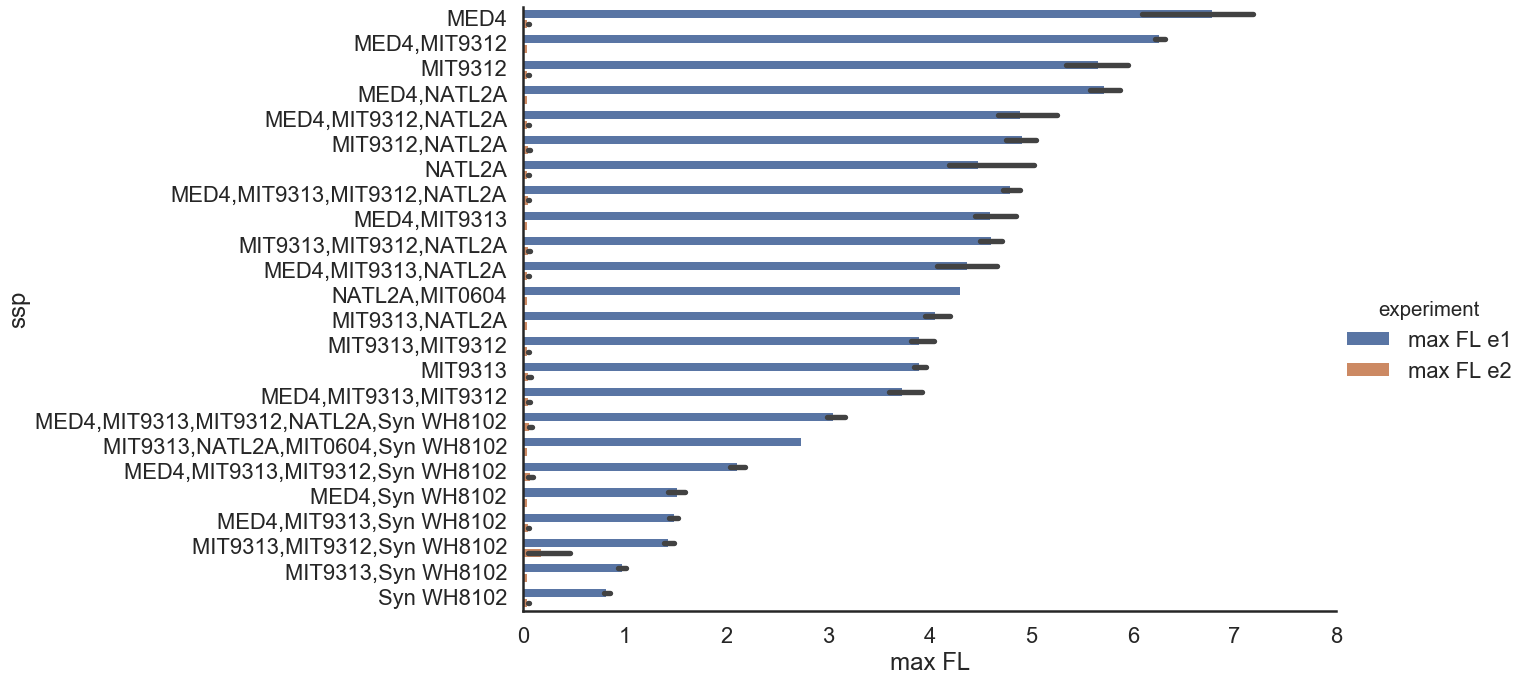

In [126]:
nl_df = pp.loc[pp['max FL e2']<0.5]
nl_df.head()
nl_df = nl_df.sort_values(by='max FL e1', axis=0, ascending=False)[['ssp', 'max FL e1', 'max FL e2']]
nl_df =pd.melt(nl_df, id_vars='ssp', value_vars=['max FL e1','max FL e2'], var_name='experiment', value_name='max FL')
sns.catplot(data=nl_df, y='ssp', hue='experiment', x='max FL', kind='bar', aspect=2, height=10)


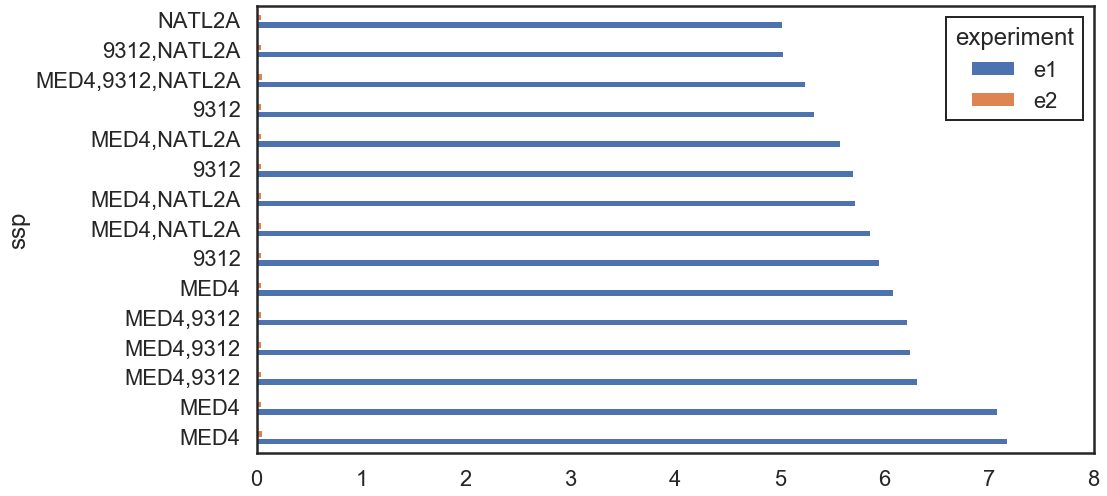

In [489]:
nl_df = data=pp.nsmallest(n=15, columns=['diff'])[['ssp', 'e1', 'e2']]
nl_df.index= nl_df.ssp
nl_df.plot(kind='barh')
            #kind='bar', y='ssp', x=['e1', 'e2'])

In [138]:
dfg.columns

Index(['Sample', 'sample_prefix', 'experiment', 'MED4', 'MIT9313', 'MIT9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate'],
      dtype='object')

In [139]:
ppmm = pd.melt(dfg, 
    id_vars=['Sample', 'sample_prefix', 'experiment', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate'],
        var_name='sp', value_vars=species )
ppmm = ppmm.loc[ppmm['value']]              

In [152]:
growing_samples = exp2_dfg.loc[exp2_dfg['max FL'] > 0.2, 'Sample']

In [153]:
ppmm2 = ppmm.loc[ppmm['Sample'].isin(growing_samples)]

In [158]:
pp2 = pp.loc[pp['Sample'].isin(growing_samples)]

In [161]:
dfg2 = dfg.loc[dfg['Sample'].isin(growing_samples)]

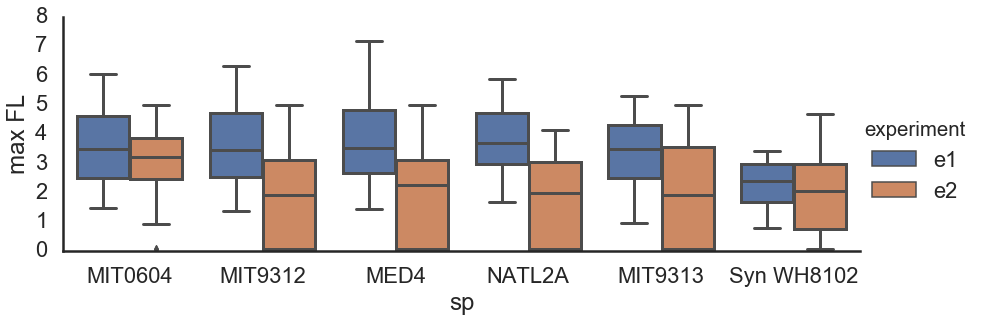

In [156]:
sns.catplot(data=ppmm, x='sp', y='max FL', kind='box', hue='experiment', aspect=2.5)

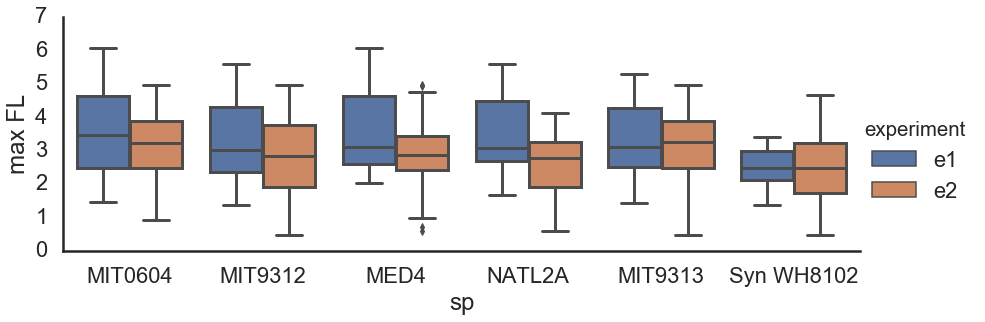

In [157]:
sns.catplot(data=ppmm2, x='sp', y='max FL', kind='box', hue='experiment', aspect=2.5)

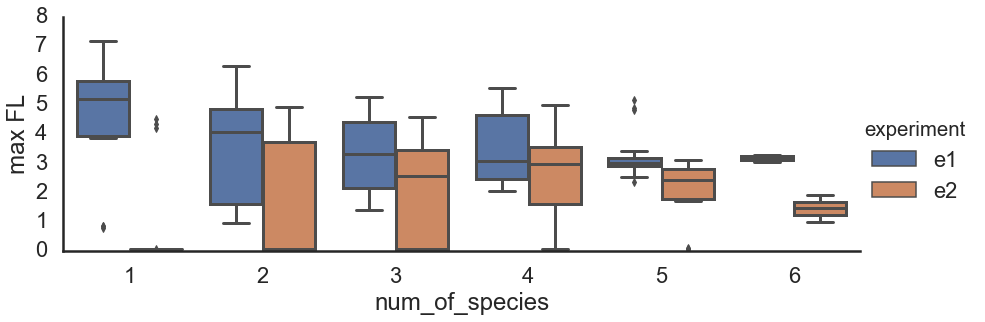

In [160]:
sns.catplot(data=dfg, x='num_of_species', y='max FL', kind='box', hue='experiment', aspect=2.5)

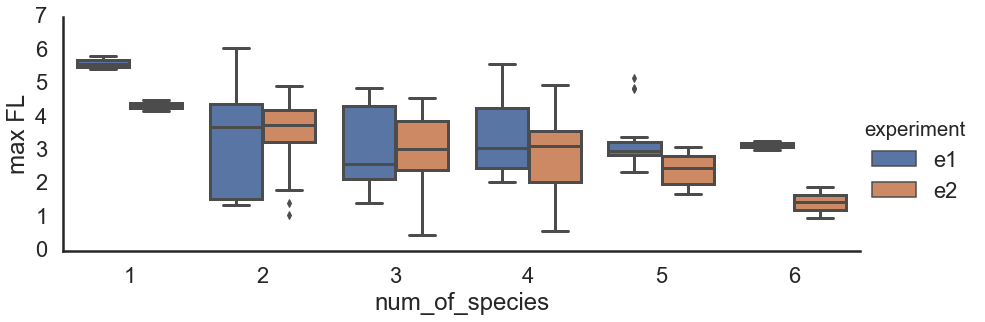

In [172]:
sns.catplot(data=dfg2, x='num_of_species', y='max FL', kind='box', hue='experiment', aspect=2.5)

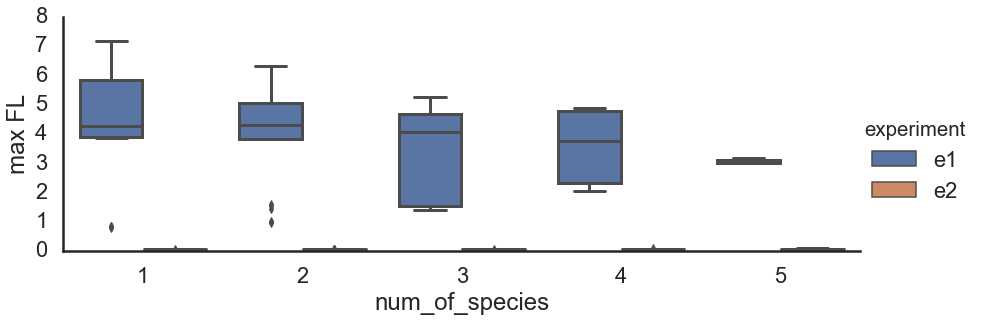

In [163]:
sns.catplot(data=dfg.loc[~dfg.Sample.isin(growing_samples)], x='num_of_species', y='max FL', kind='box', hue='experiment', aspect=2.5)

In [164]:
exp1_dfg.columns

Index(['Sample', 'sample_prefix', 'experiment', 'MED4', 'MIT9313', 'MIT9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'max FL',
       'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate'],
      dtype='object')

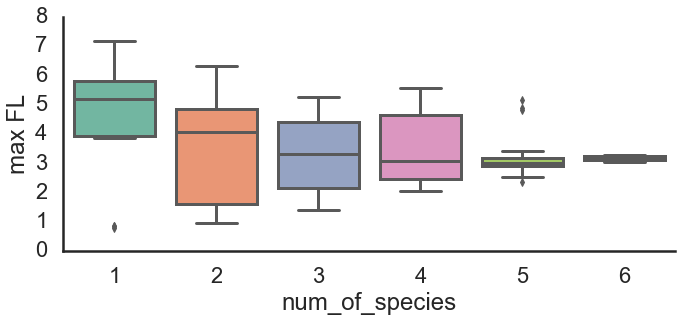

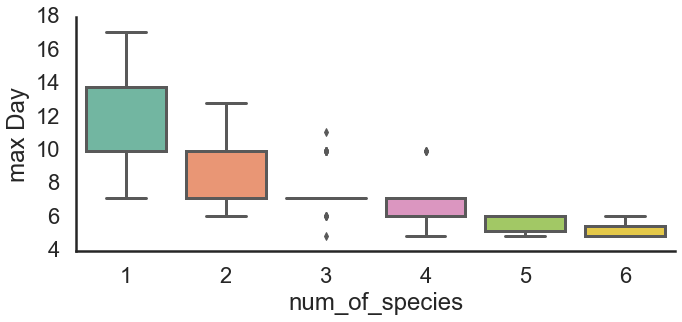

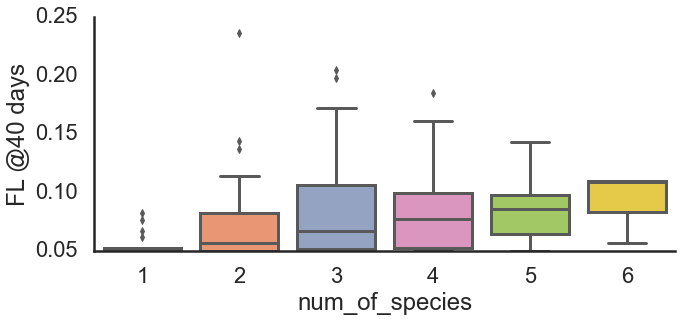

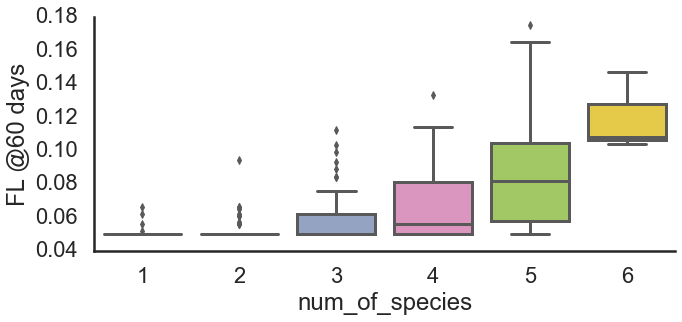

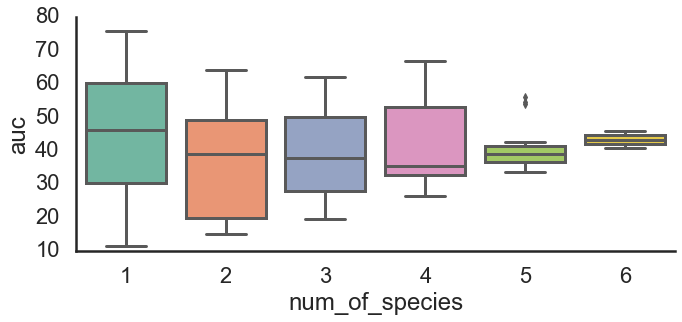

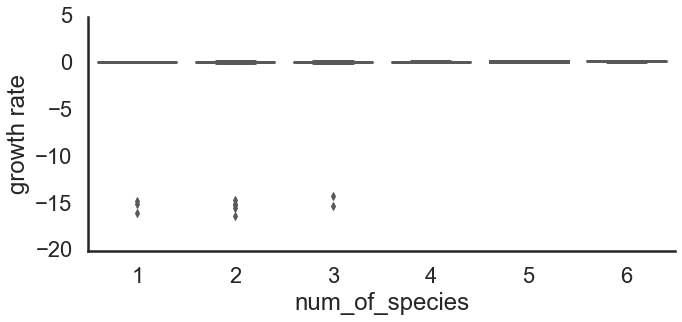

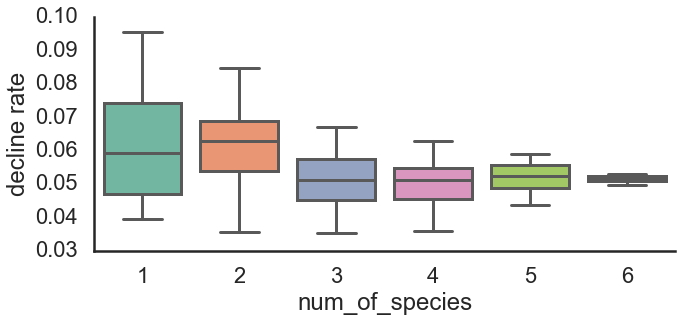

In [170]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate','decline rate']:
    sns.catplot(data=exp1_dfg, x='num_of_species', y=i, kind='box', palette='Set2',# hue='num_of_species',
                aspect=2)

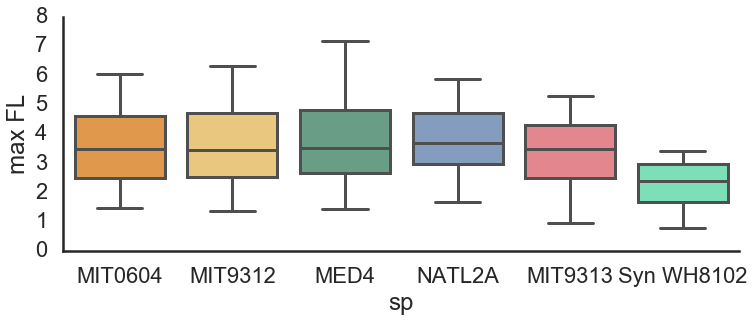

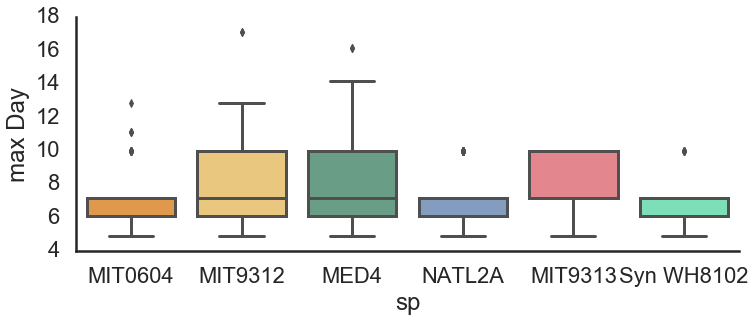

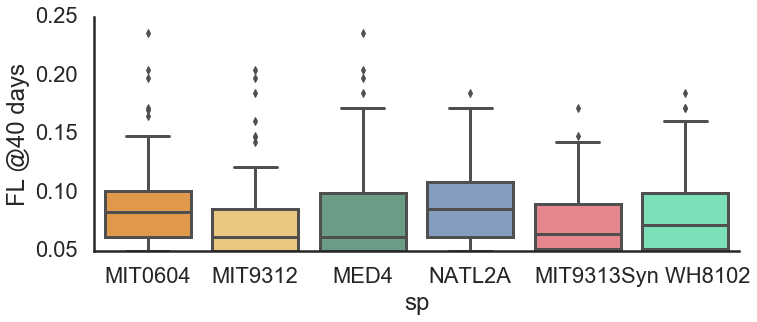

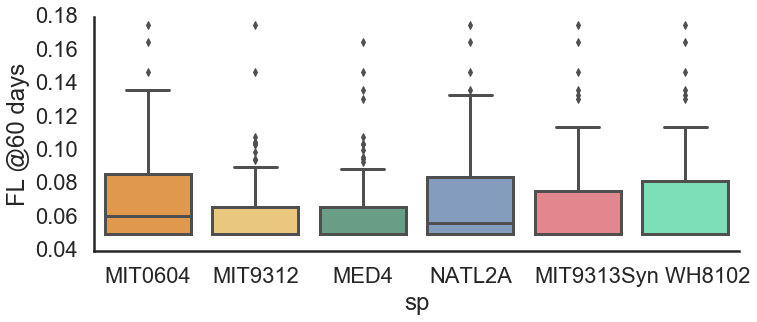

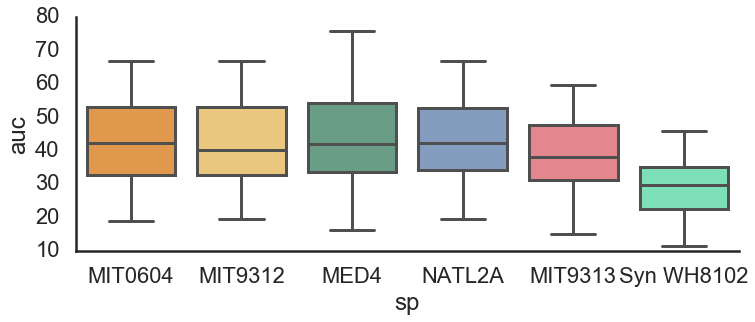

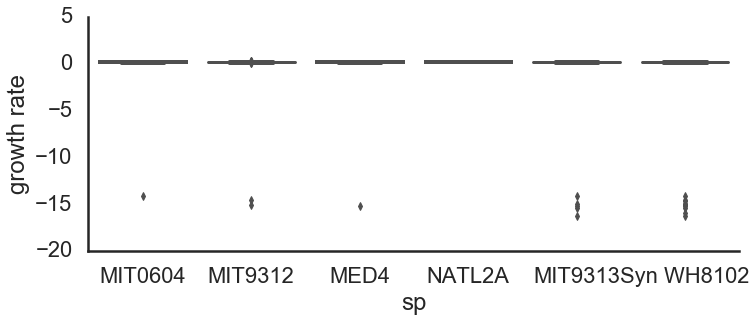

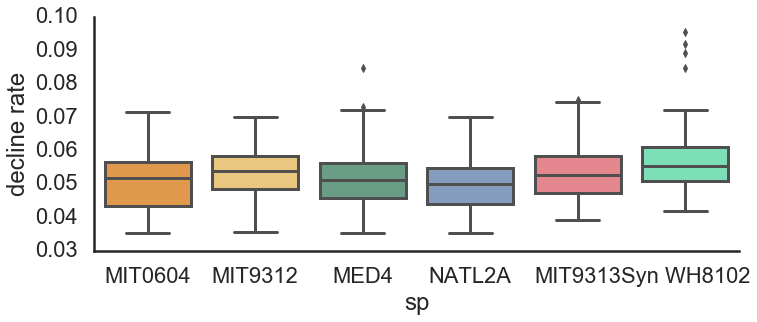

In [184]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate','decline rate']:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                x='sp', y=i, kind='box', palette=ppallete, order=species, # hue='num_of_species',
                aspect=2.2)

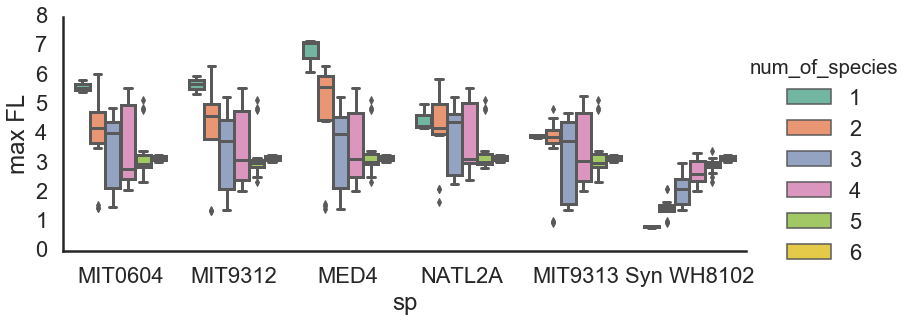

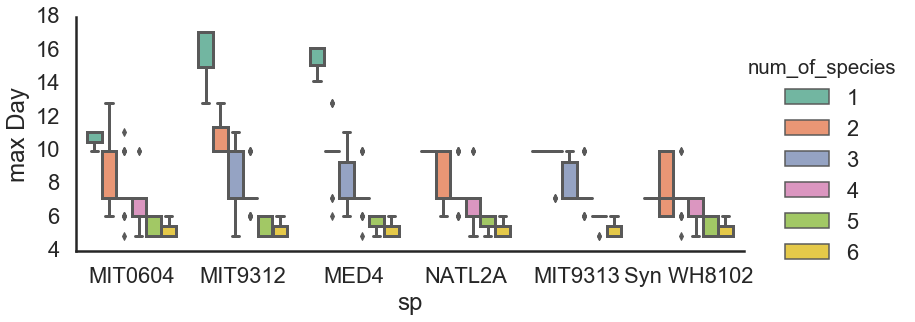

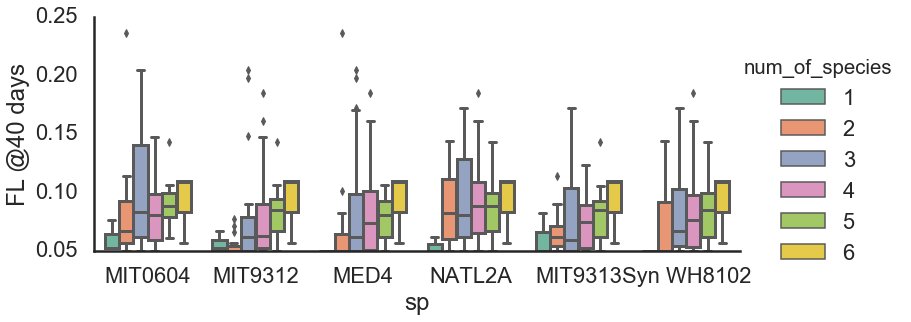

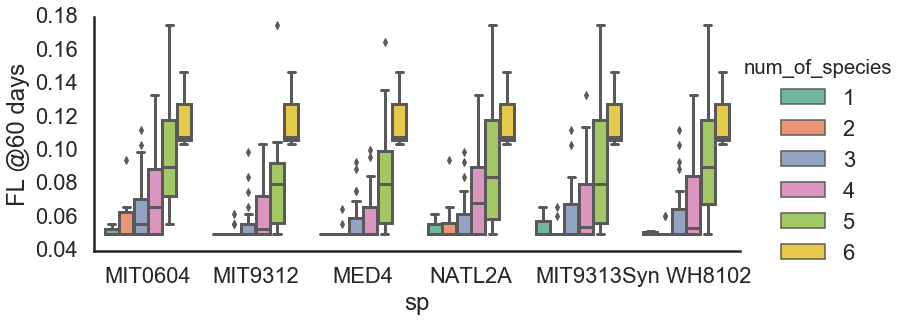

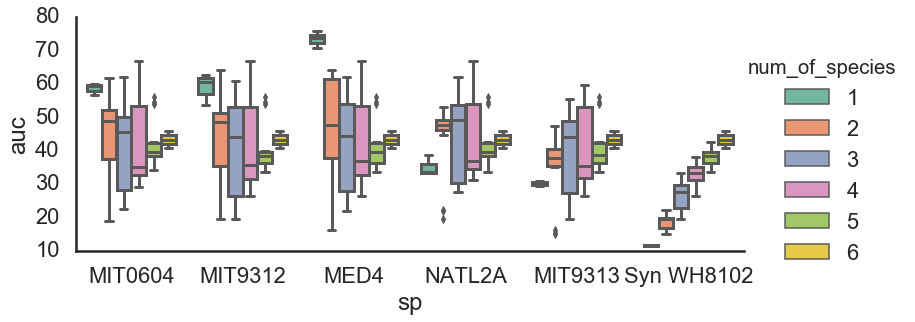

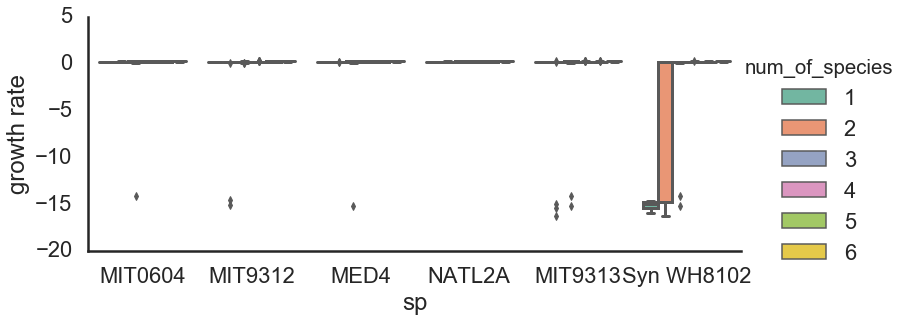

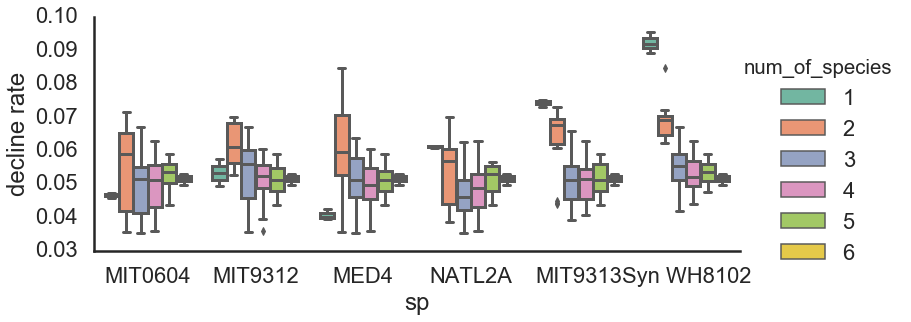

In [185]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate','decline rate']:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                x='sp', y=i, kind='box', palette='Set2', 
                order=species, hue='num_of_species',
                aspect=2.2)

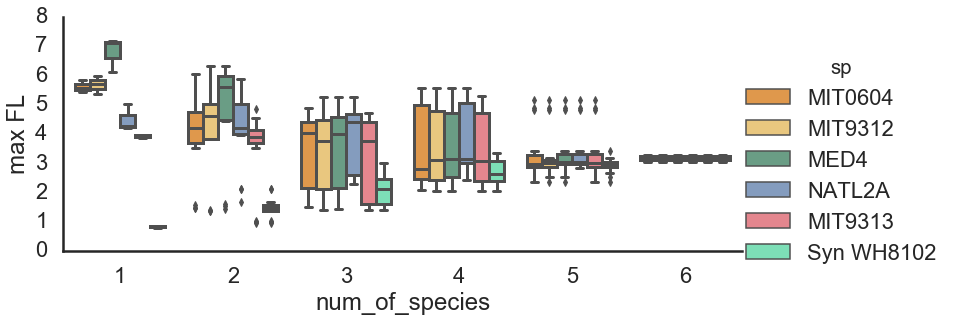

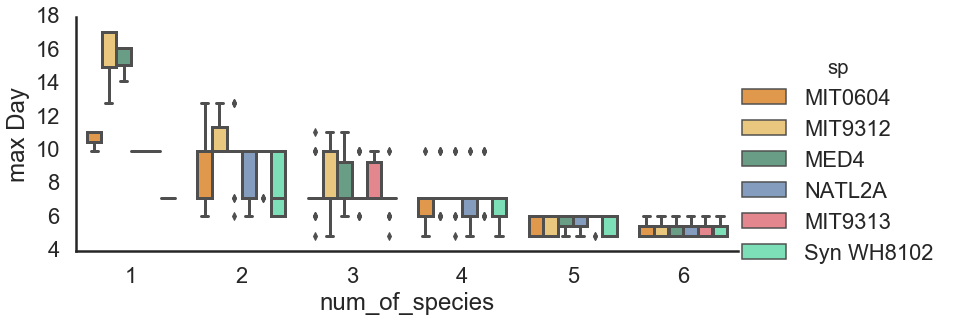

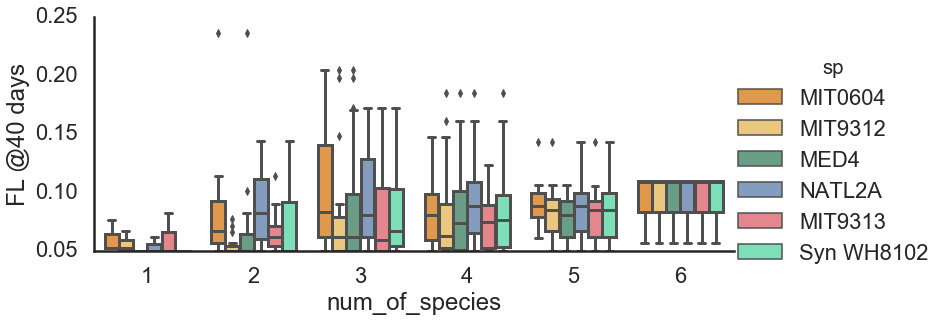

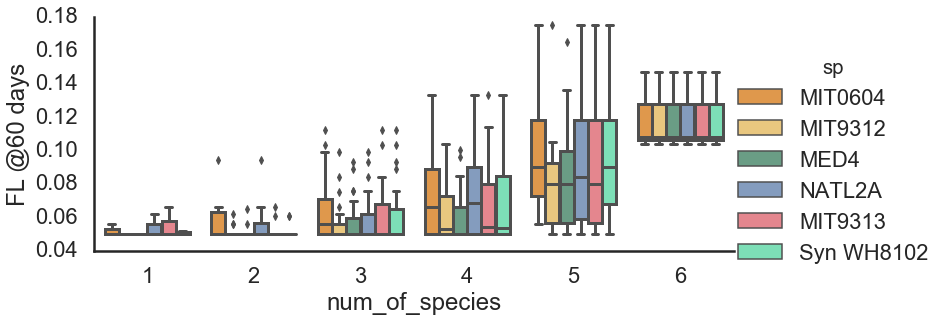

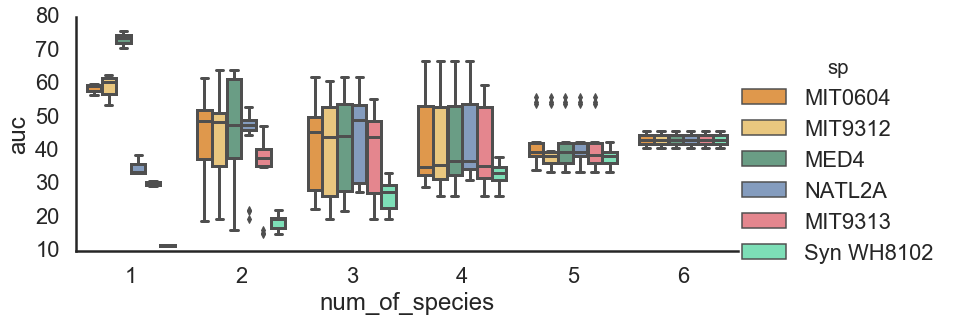

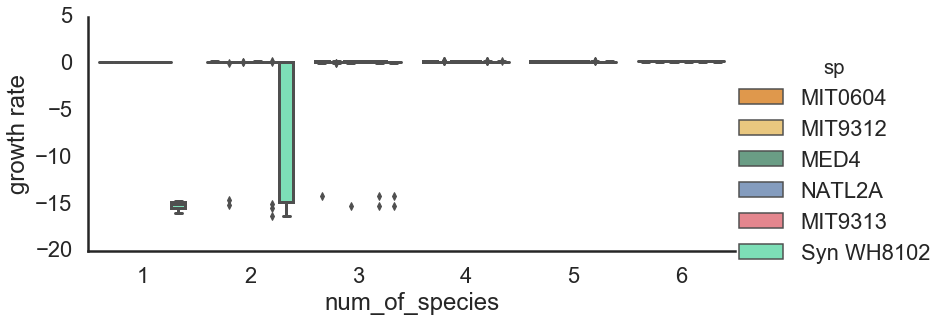

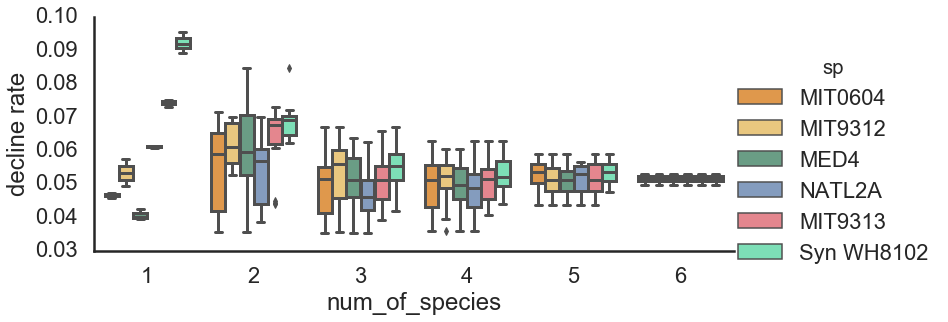

In [186]:
for i in ['max FL','max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate','decline rate']:
    sns.catplot(data=ppmm.loc[ppmm.experiment=='e1'], 
                hue='sp', y=i, kind='box', palette=ppallete, 
                hue_order=species, x='num_of_species',
                aspect=2.2)

In [188]:
pp.columns

Index(['Sample', 'sample_prefix', 'MED4', 'MIT9313', 'MIT9312', 'NATL2A',
       'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL @40 days e1',
       'FL @60 days e1', 'auc e1', 'auc e2', 'decline rate e1',
       'growth rate e1', 'max Day e1', 'max Day e2', 'max FL e1', 'max FL e2',
       'diff max FL'],
      dtype='object')

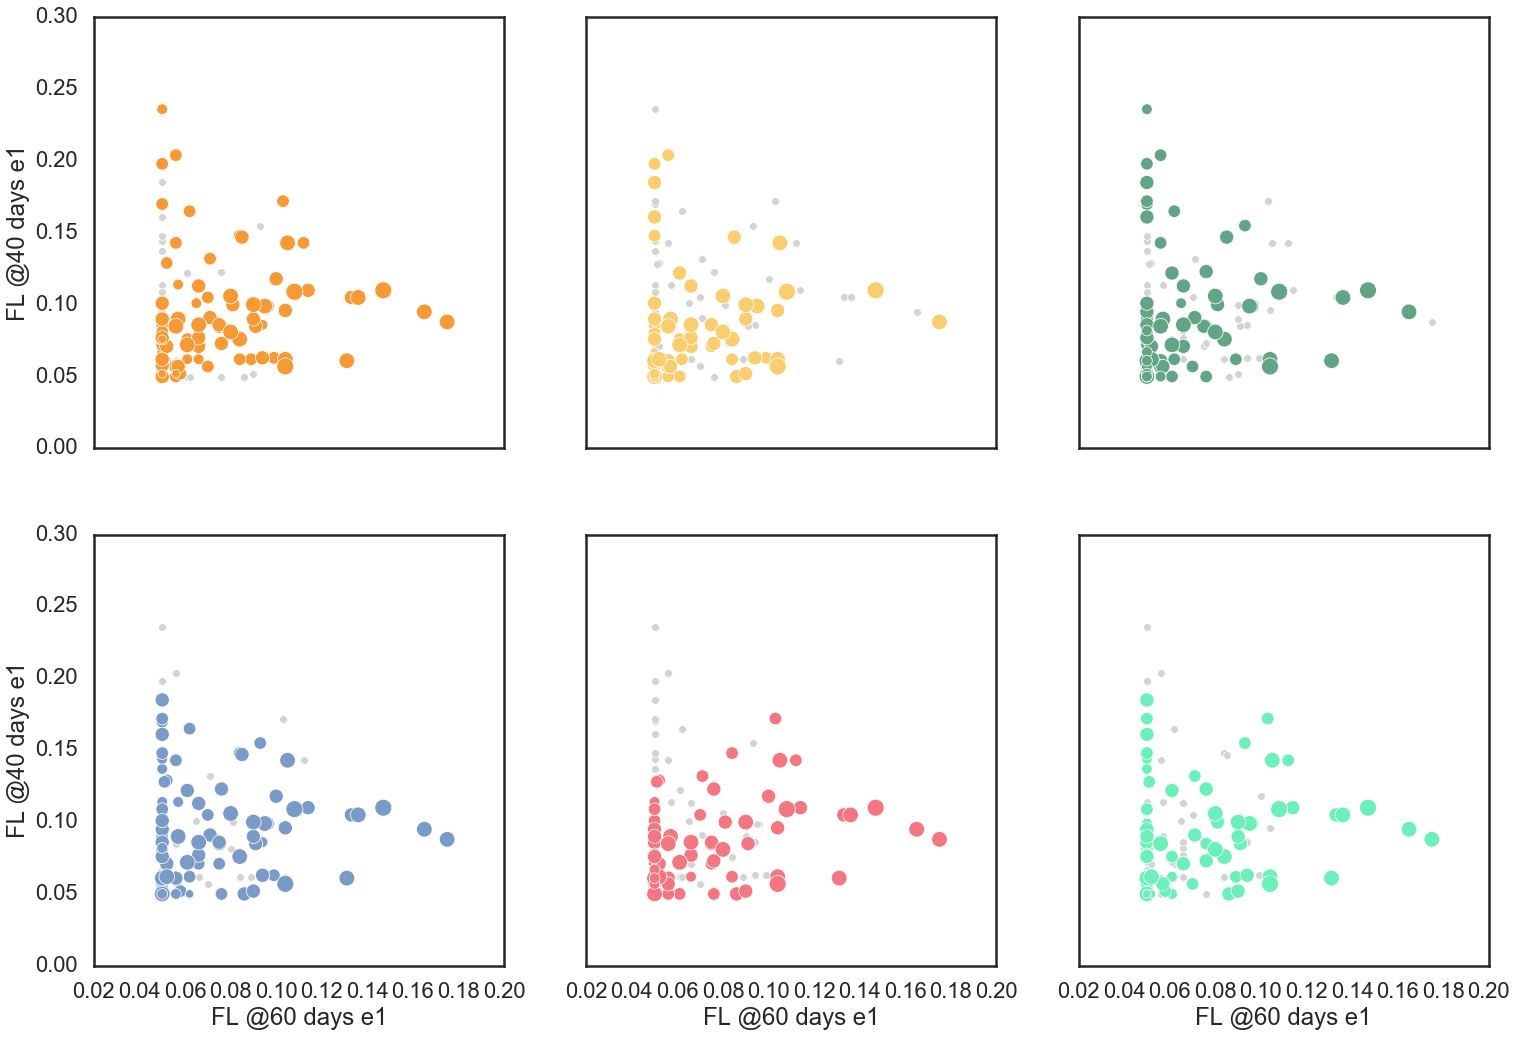

In [210]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(25,17))
    
for idx,i in enumerate(species):
    sns.scatterplot(data=pp, # .loc[pp['max FL e2']> 0.5], 
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=60, #size='num_of_species', 
                     color=other_color, 
                    ax=axs[idx//3, idx%3])
    sns.scatterplot(data=pp.loc[pp[i]], # & (pp['max FL e2']> 0.5)],
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=80, size='num_of_species',  
                    #label=i,
                    color=color_dict[i]
                   , ax=axs[idx//3, idx%3],
                   legend=False
                   )

#plt.legend(loc='best')
#leg = g.get_legend()

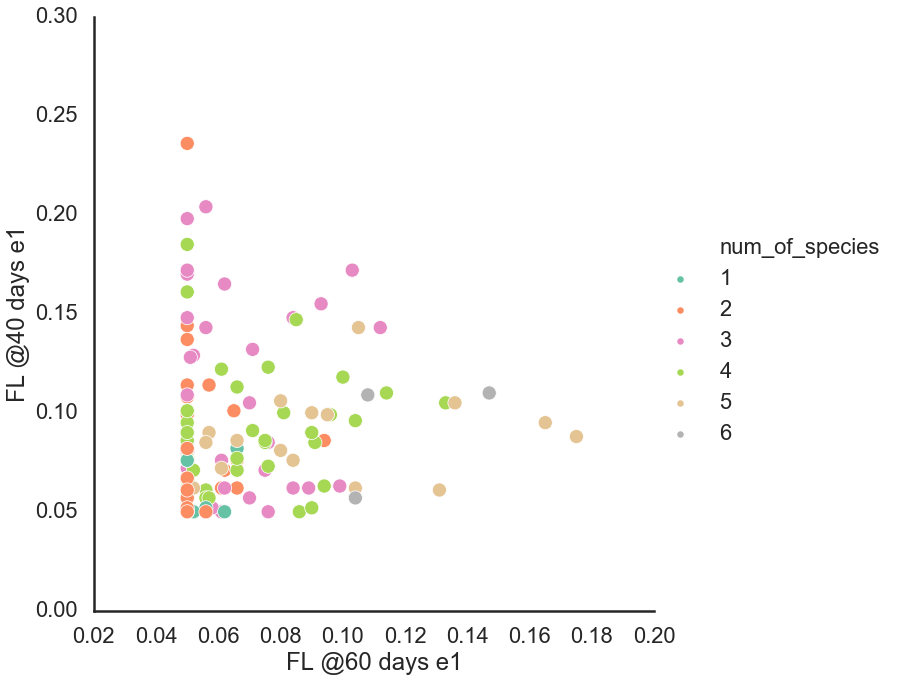

In [199]:
    sns.relplot(data=pp, # .loc[pp['max FL e2']> 0.5], 
                    x='FL @60 days e1', y='FL @40 days e1', 
                    s=200, hue='num_of_species', 
                    palette='Set2', legend='full', #legend_out=True,
                    #aspect=1.6, 
                height=10, 
                   )

/store_data/Osnat/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


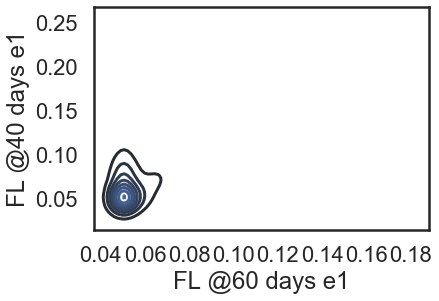

In [204]:
    sns.kdeplot(pp['FL @60 days e1'], pp['FL @40 days e1'],
                    #s=200, 
                hue=pp['num_of_species'], 
                    #palette='Set2', legend='full', #legend_out=True,
                    #aspect=1.6, 
                #height=10, 
                   )

In [173]:
ppmm.columns

Index(['Sample', 'sample_prefix', 'experiment', 'num_of_species', 'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate', 'sp', 'value'],
      dtype='object')

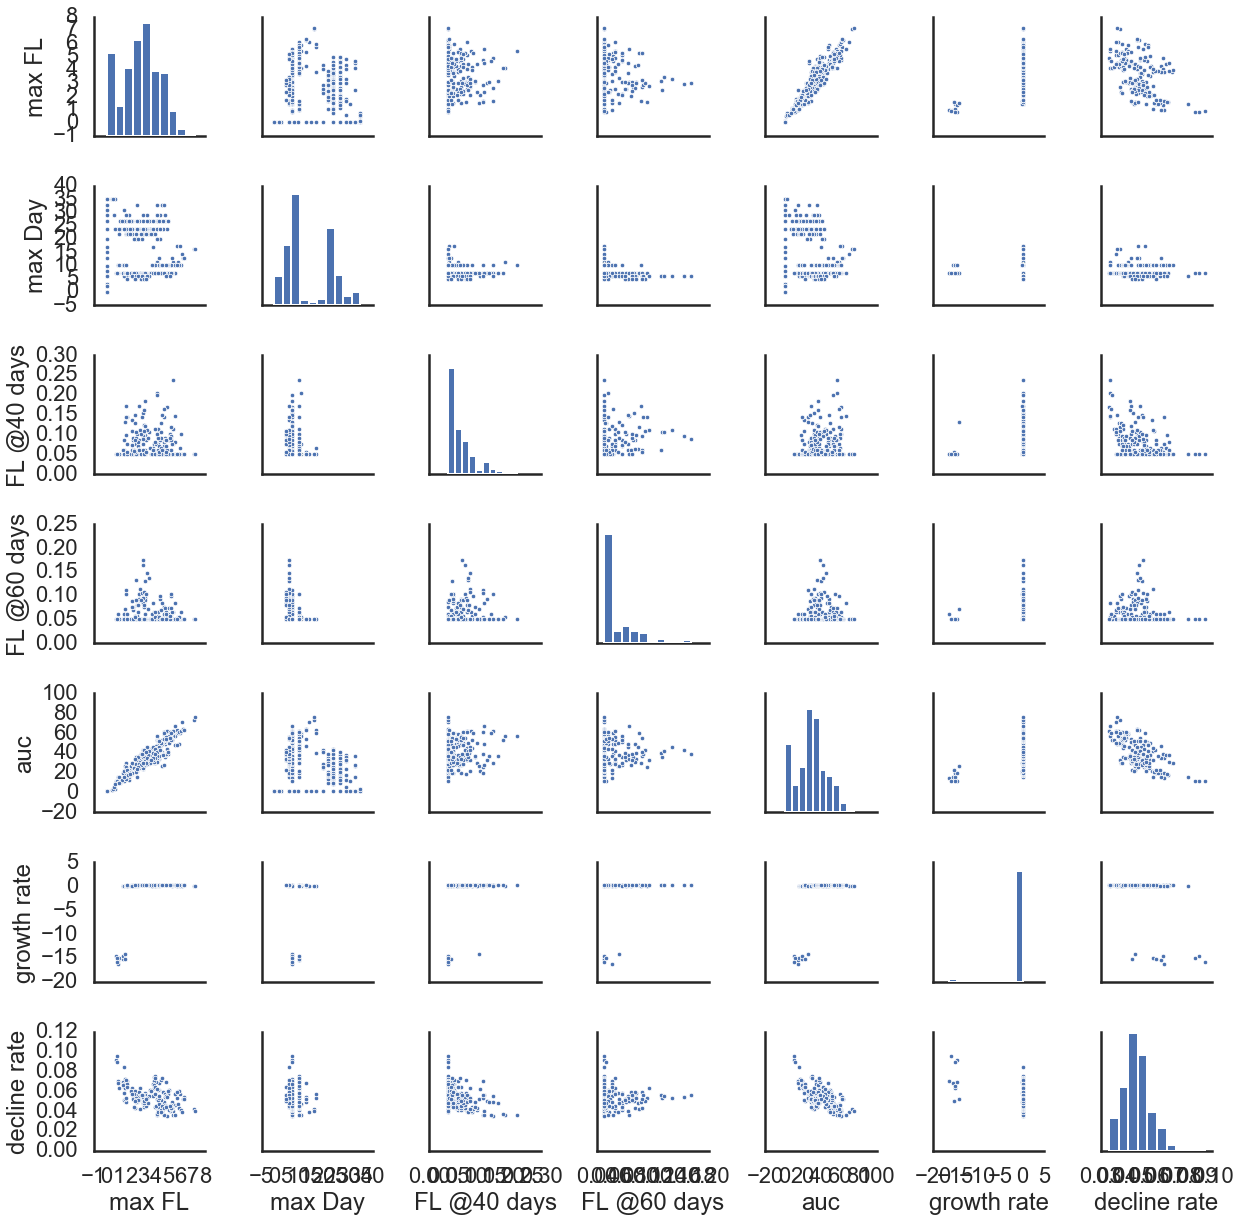

In [176]:
sns.pairplot(data=ppmm[['Sample', 'experiment',  'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate', 'sp']])

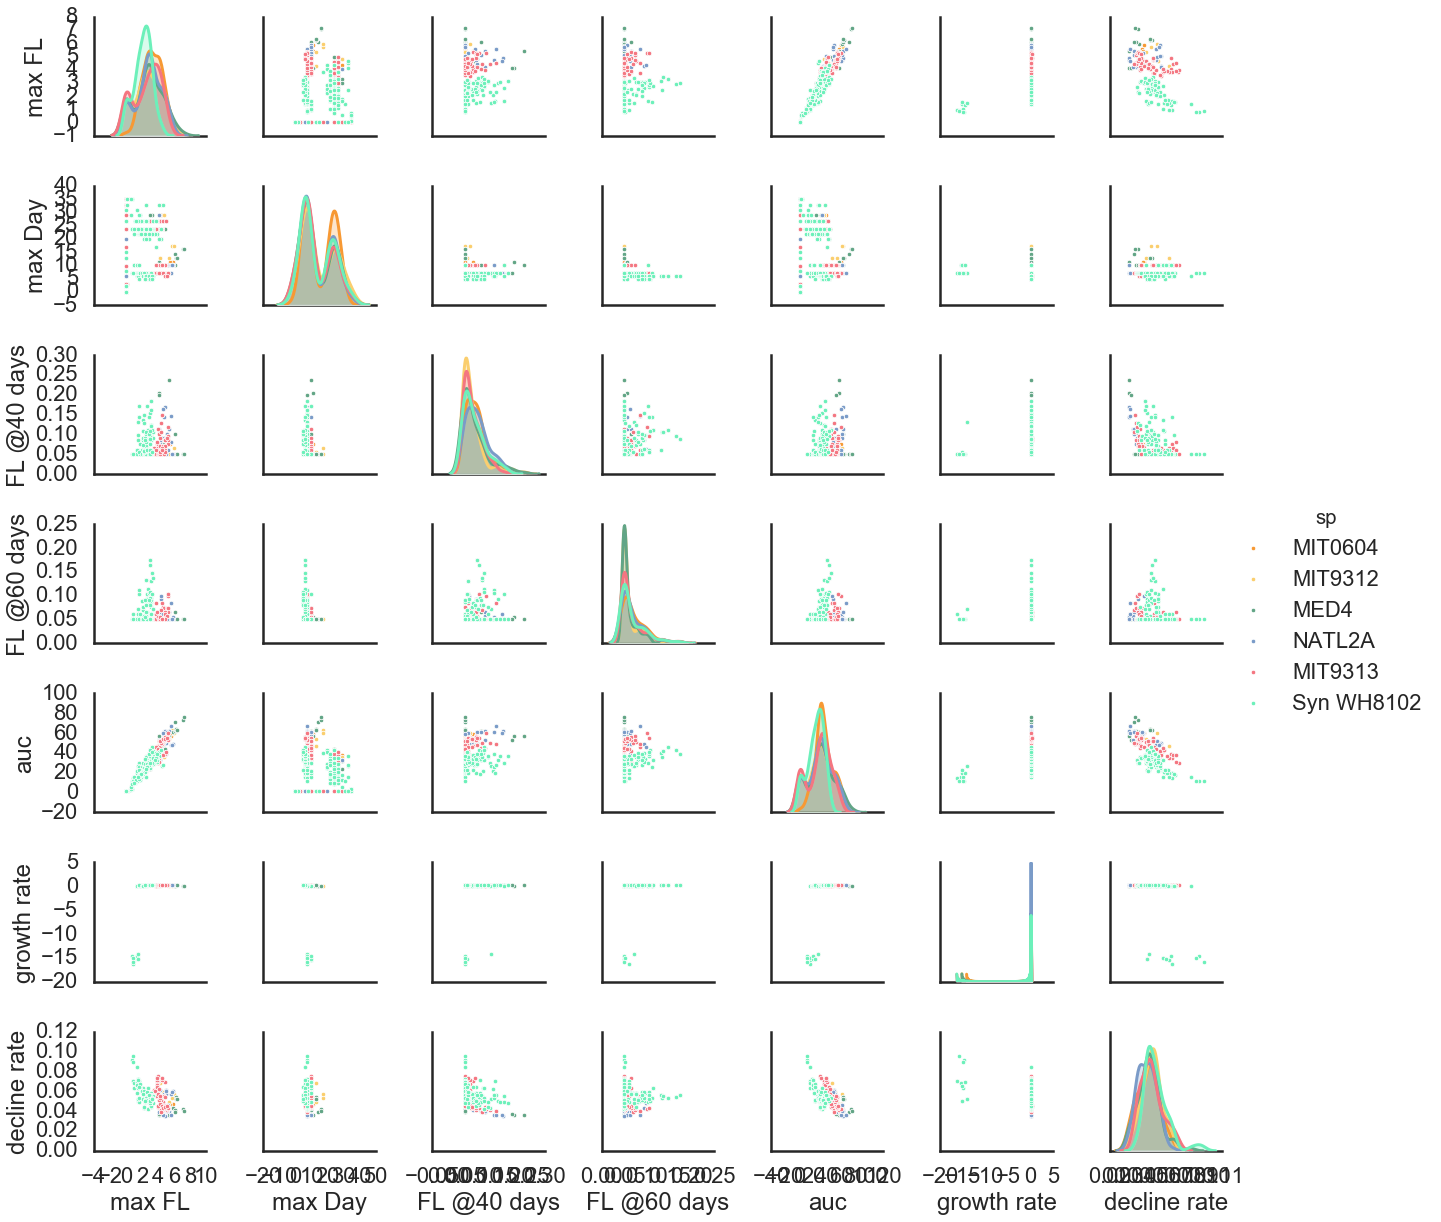

In [187]:
sns.pairplot(data=ppmm[['Sample', 'experiment',  'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate', 'sp']],
            hue='sp', hue_order=species, palette=ppallete)

In [179]:
ppmm.columns

Index(['Sample', 'sample_prefix', 'experiment', 'num_of_species', 'ssp',
       'max FL', 'max Day', 'FL @40 days', 'FL @60 days', 'auc', 'growth rate',
       'decline rate', 'sp', 'value'],
      dtype='object')

In [131]:
species

['MED4', '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102']

In [139]:
from itertools import combinations
len(list(combinations(species, 5)))

6

In [264]:
from itertools import combinations_with_replacement
len(list(combinations_with_replacement(['NATL2A', 'MIT0604', 'Syn WH8102'], 3)))

10

# PCA

In [287]:
sample_col = 'Sample'
X = cp.experiments2X(exp1_df, value_col='FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp1_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=3)

Variance percent explained
 [0.37024478 0.19124829 0.11468434]


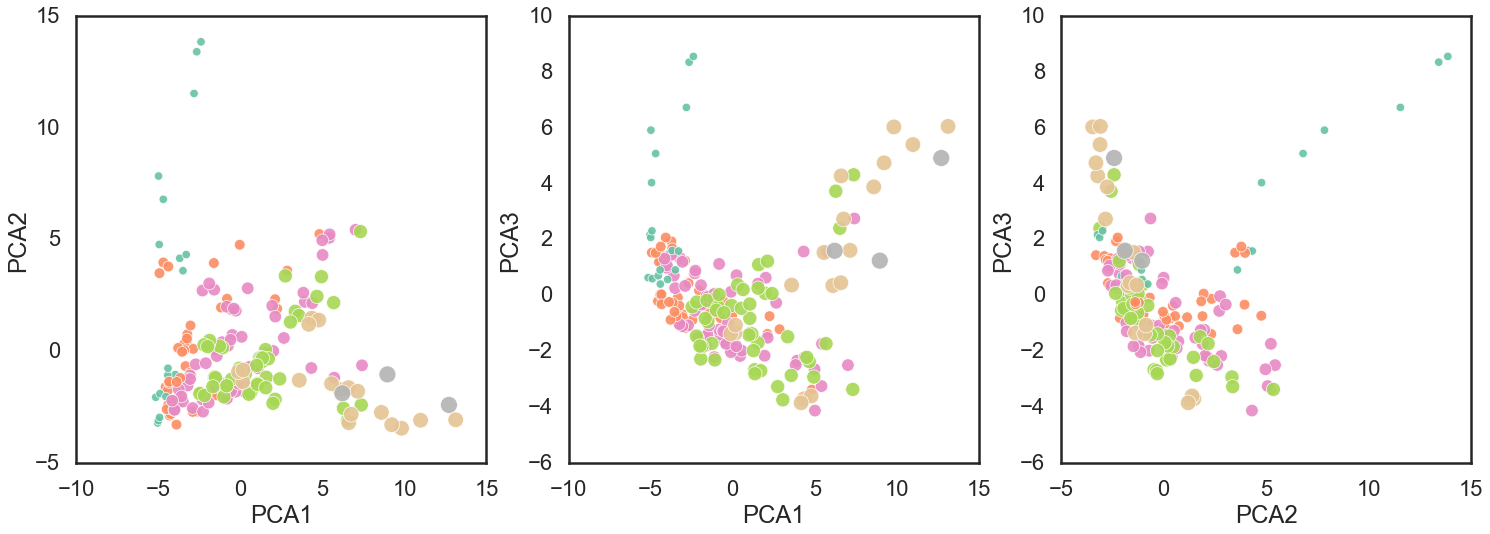

In [288]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, hue='num_of_species', 
            size='num_of_species', palette='Set2',
            s=100, alpha=0.9, #height=7, aspect=1.2,
            legend=False, 
                ax=axs[j]
           )

#plt.legend(bbox_to_anchor=(2,1))

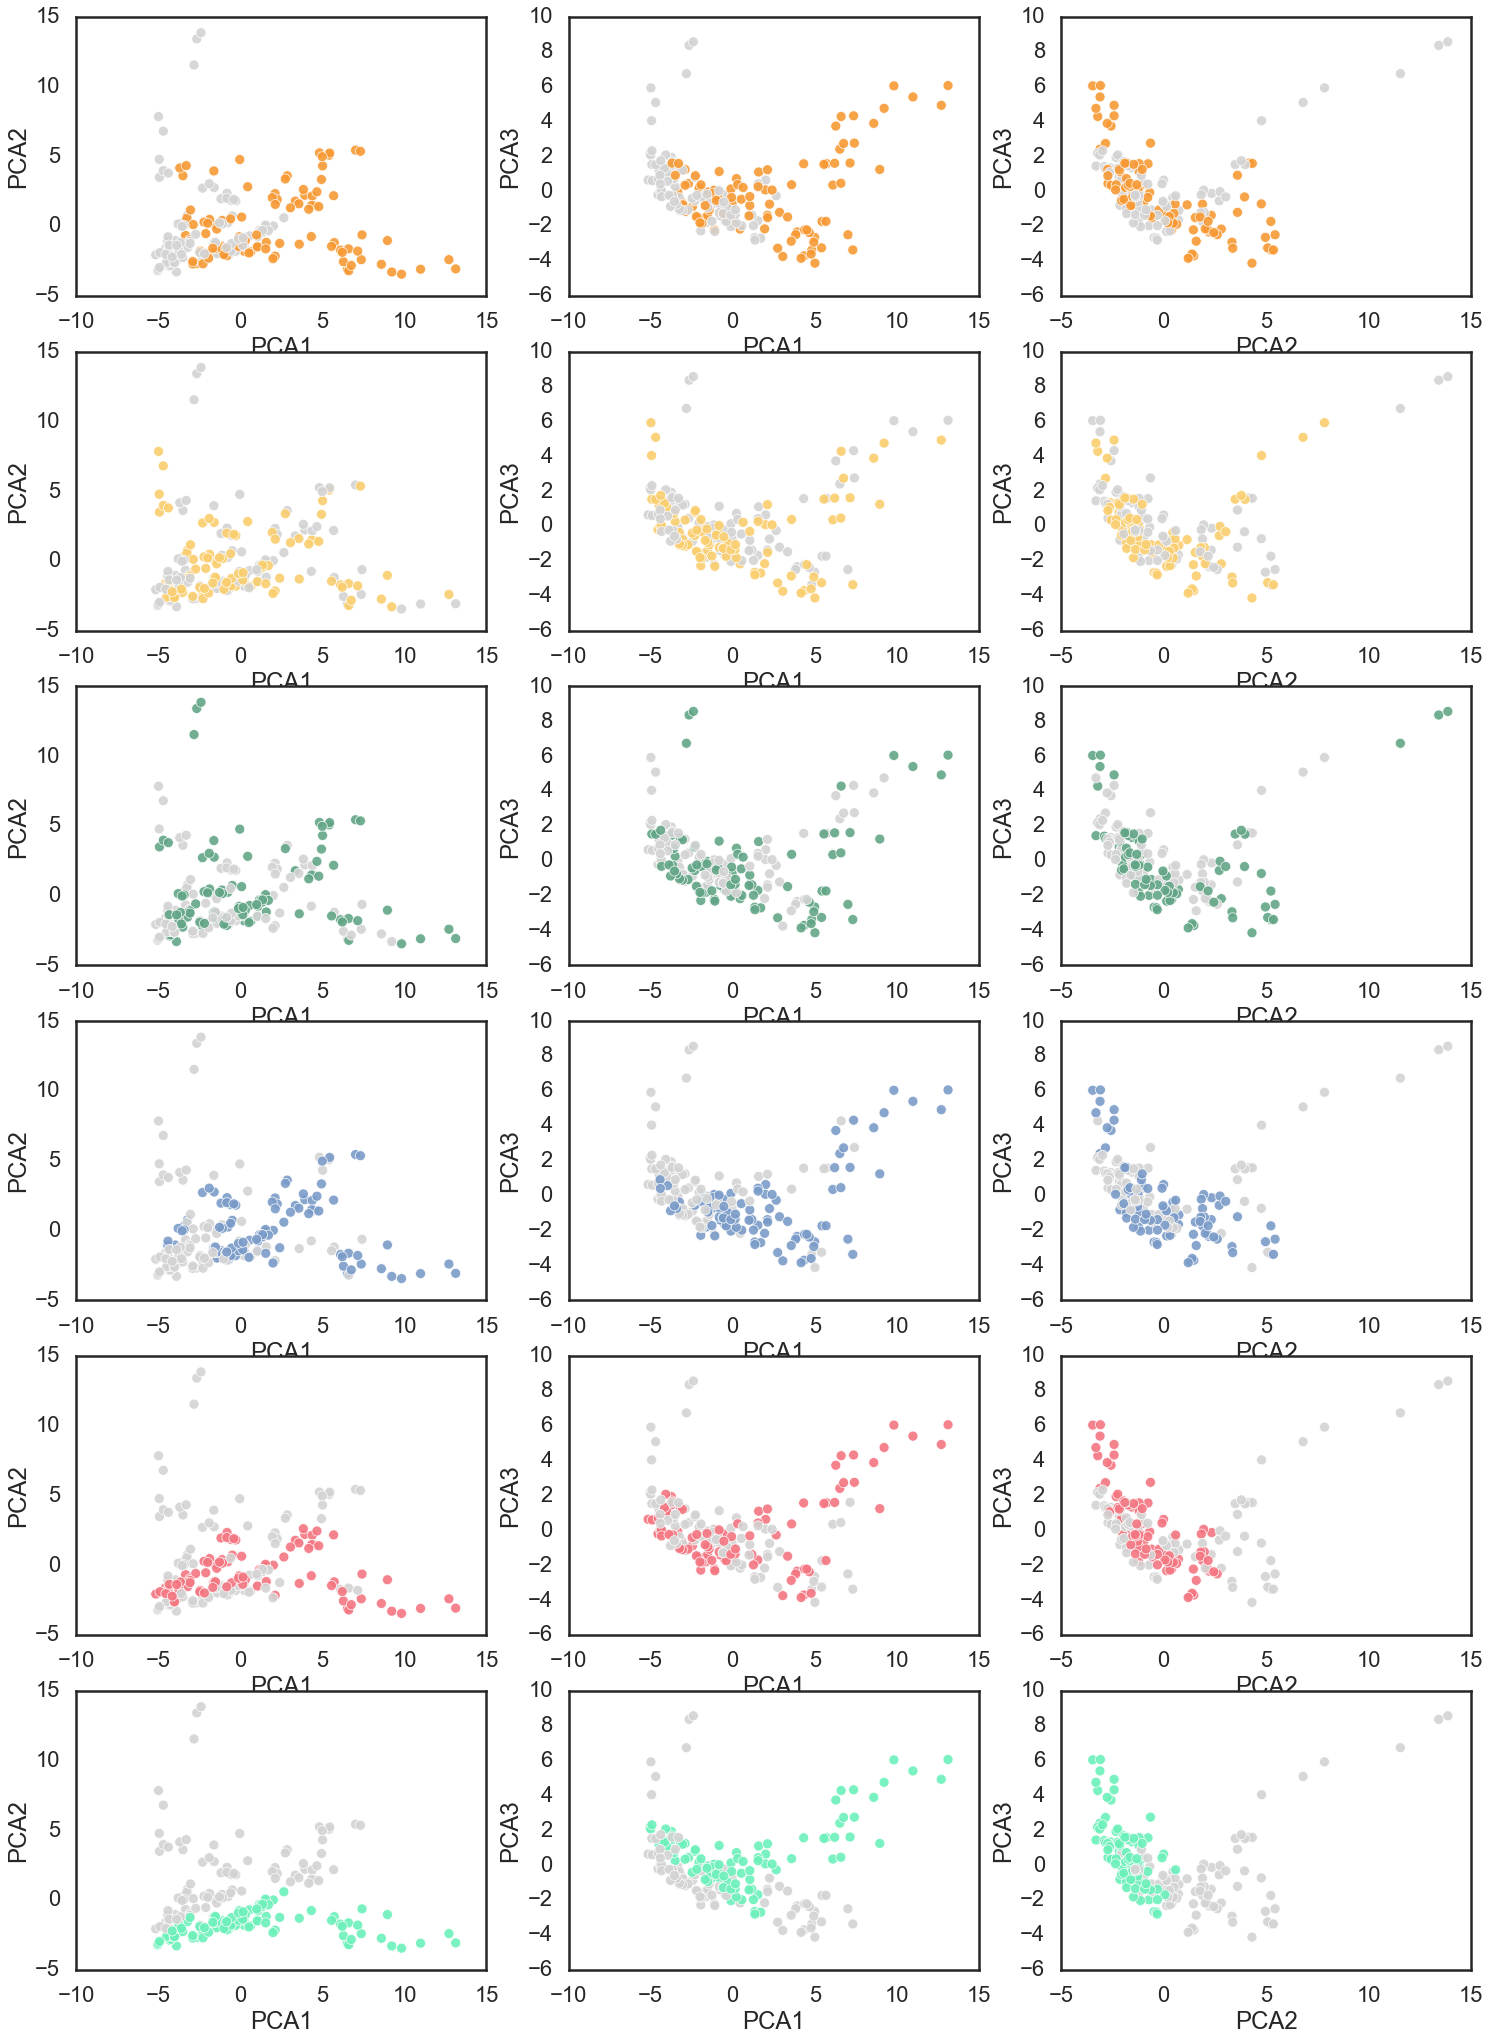

In [289]:
fig, axs = plt.subplots(6, 3, figsize=(25,35)) #, sharex=True, sharey=True)
for idx,i in enumerate(species):
#fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
#                        figsize=(25, 8))

    for j,x,y  in [(0,'PCA1', 'PCA2'),
                   (1,'PCA1', 'PCA3'),
                   (2,'PCA2', 'PCA3'),
                  ]:
        sns.scatterplot(data=dfpca, x=x, y=y, hue=i, 
                #size=i, #palette='Set2',
                s=100, alpha=0.9, #height=7, aspect=1.2,
                legend=False, 
                    ax=axs[idx,j],
                    palette=[other_color, color_dict[i]],                
           )

No handles with labels found to put in legend.


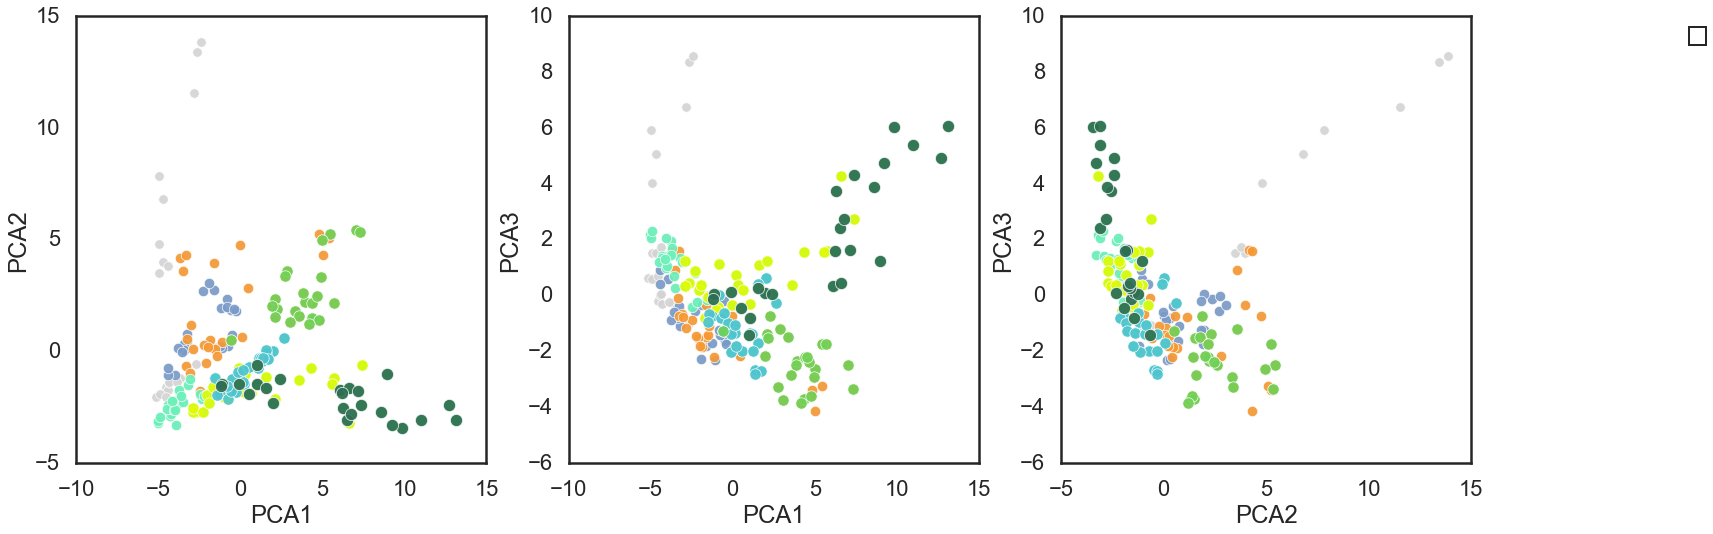

In [290]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, 
                s=90, alpha=0.9, #height=5, aspect=1.2,
                color=other_color, #label='other', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=Natl2A_color, #label='NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=MIT0604_color, #label='MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=SYN_color, #label='Syn WH8102', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_0606_color, #label='Syn WH8102 & MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_color, #label='Syn WH8102 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=natl_0604_color, #label='MIT0604 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=150, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_0604_color, #label='Syn WH8102 & NATL2A & MIT0604', 
                    ax=axs[j])
#plt.legend(False)
plt.legend(bbox_to_anchor=(1.6, 1))

In [291]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df, value_col='FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       'MIT9313', 'MIT9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=3)

Variance percent explained
 [0.35325744 0.2615291  0.09441926]


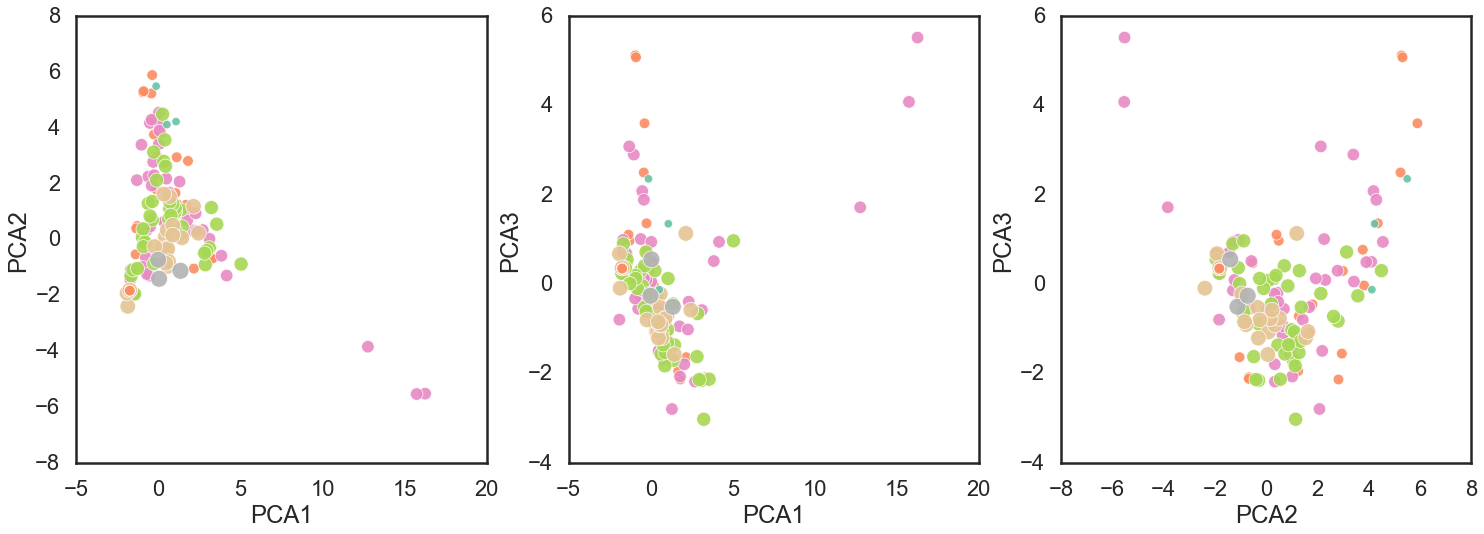

In [292]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, hue='num_of_species', 
            size='num_of_species', palette='Set2',
            s=100, alpha=0.9, #height=7, aspect=1.2,
            legend=False, 
                ax=axs[j]
           )

#plt.legend(bbox_to_anchor=(2,1))

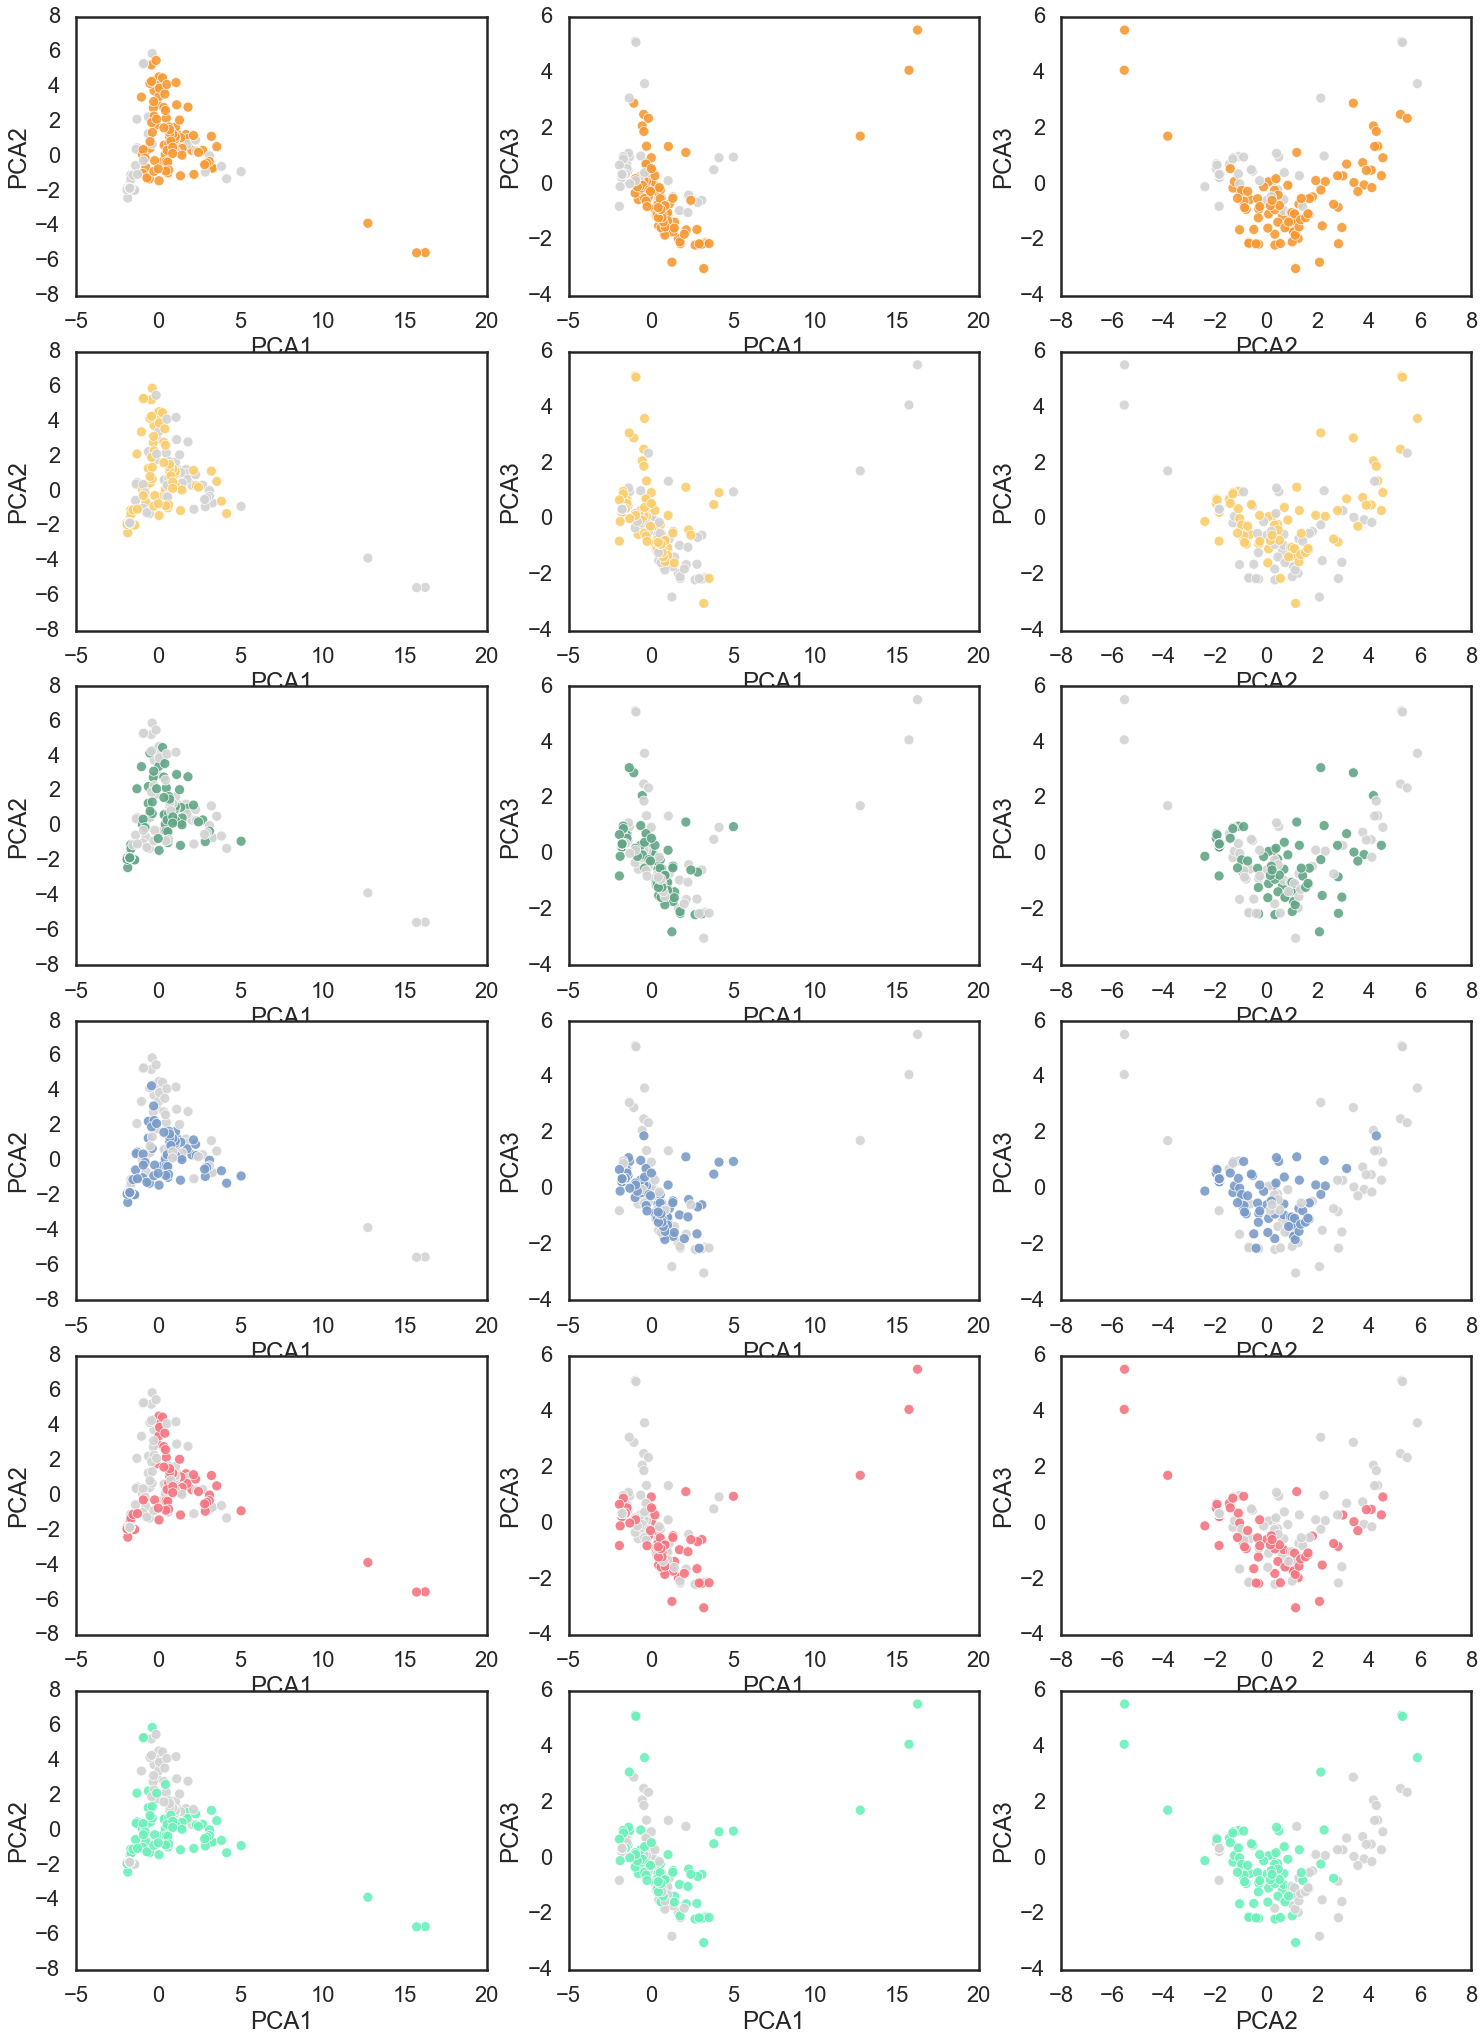

In [293]:
fig, axs = plt.subplots(6, 3, figsize=(25,35)) #, sharex=True, sharey=True)
for idx,i in enumerate(species):
#fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
#                        figsize=(25, 8))

    for j,x,y  in [(0,'PCA1', 'PCA2'),
                   (1,'PCA1', 'PCA3'),
                   (2,'PCA2', 'PCA3'),
                  ]:
        sns.scatterplot(data=dfpca, x=x, y=y, hue=i, 
                #size=i, #palette='Set2',
                s=100, alpha=0.9, #height=7, aspect=1.2,
                legend=False, 
                    ax=axs[idx,j],
                    palette=[other_color, color_dict[i]],                
           )

No handles with labels found to put in legend.


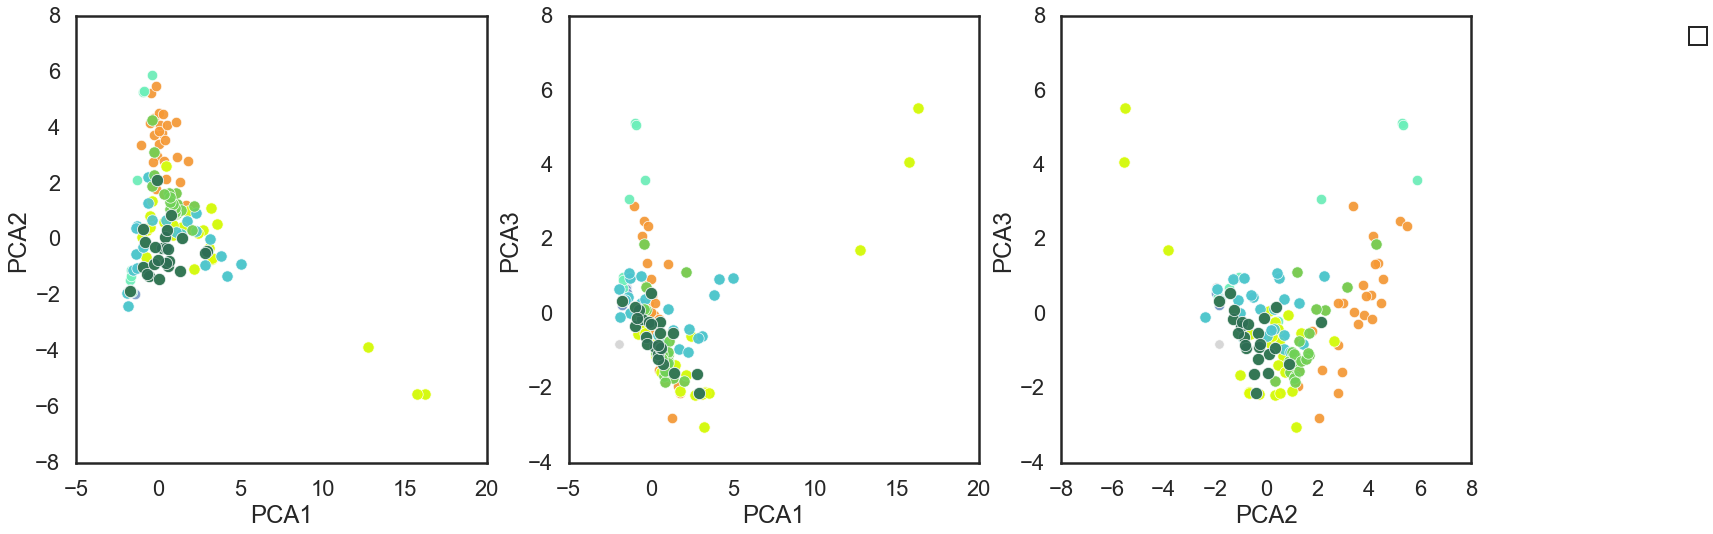

In [294]:
fig, axs = plt.subplots(1, 3, #sharex=True, sharey=True, 
                        figsize=(25, 8))
for j,x,y  in [(0,'PCA1', 'PCA2'),
               (1,'PCA1', 'PCA3'),
               (2,'PCA2', 'PCA3'),
              ]:
    sns.scatterplot(data=dfpca, x=x, y=y, 
                s=90, alpha=0.9, #height=5, aspect=1.2,
                color=other_color, #label='other', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=Natl2A_color, #label='NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=MIT0604_color, #label='MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                    x=x, y=y, 
                s=110, alpha=0.9, #height=5, aspect=1.2,
                color=SYN_color, #label='Syn WH8102', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_0606_color, #label='Syn WH8102 & MIT0604', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_color, #label='Syn WH8102 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                    x=x, y=y, 
                s=130, alpha=0.9, #height=5, aspect=1.2,
                color=natl_0604_color, #label='MIT0604 & NATL2A', 
                    ax=axs[j])
    sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                    x=x, y=y, 
                s=150, alpha=0.9, #height=5, aspect=1.2,
                color=syn_natl_0604_color, #label='Syn WH8102 & NATL2A & MIT0604', 
                    ax=axs[j])
#plt.legend(False)
plt.legend(bbox_to_anchor=(1.6, 1))

# cluster exp2

In [296]:
sample_col = 'Sample'
X = cp.experiments2X(exp2_df, value_col='FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp2_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

KeyError: '9313'

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='num_of_species', 
            size='num_of_species',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

In [420]:
dfpca.columns

Index(['SNE1', 'SNE2', 'Sample', 'sample_prefix', 'MED4', '9313', '9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL'],
      dtype='object')

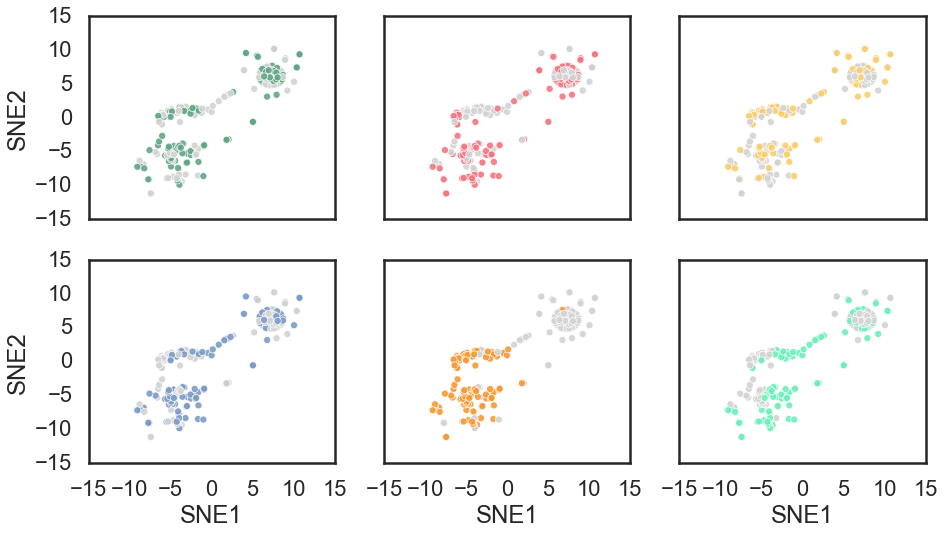

In [421]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

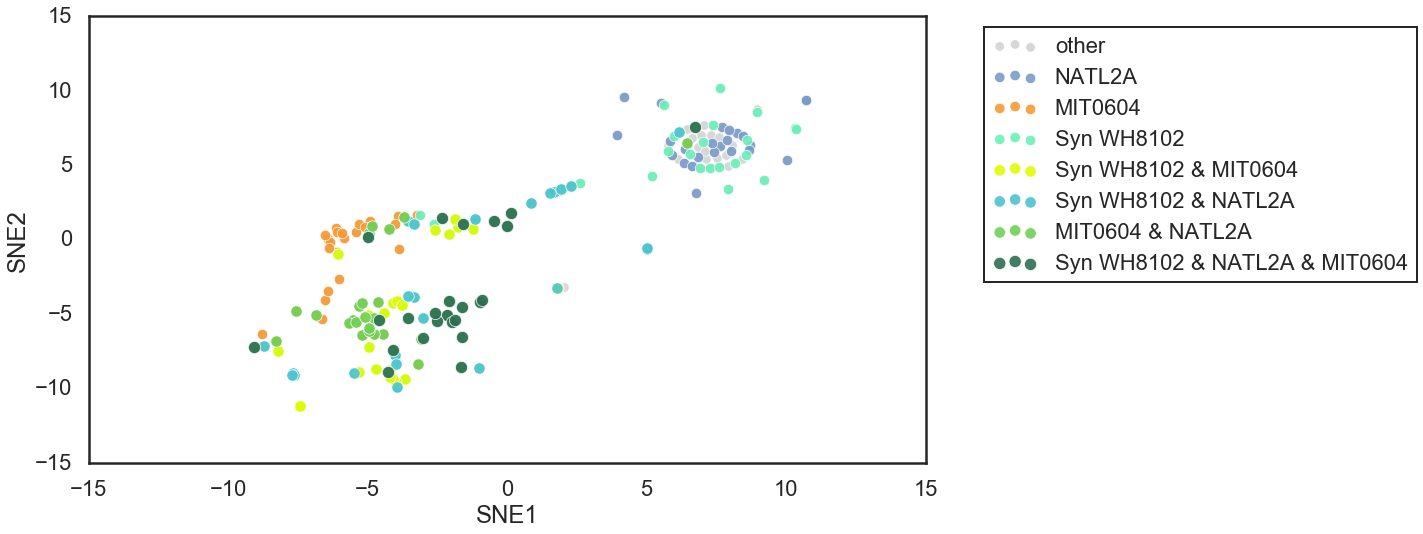

In [422]:
sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

# cluster exp1

In [412]:
sample_col = 'Sample'
X = cp.experiments2X(exp1_df, value_col='FL', sample_col='Sample', x_col='Day', cumsummode=False)
metadf = cp.get_meta(exp1_df, meta_col=['Sample', 'sample_prefix', 'MED4',
       '9313', '9312', 'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species',
       'ssp'])
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

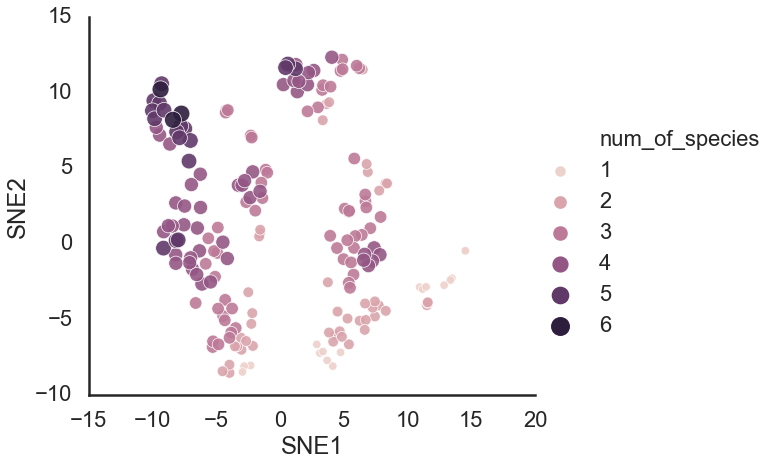

In [414]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='num_of_species', 
            size='num_of_species',
            s=50, alpha=0.9, height=7, aspect=1.2,
            legend='full'
           )

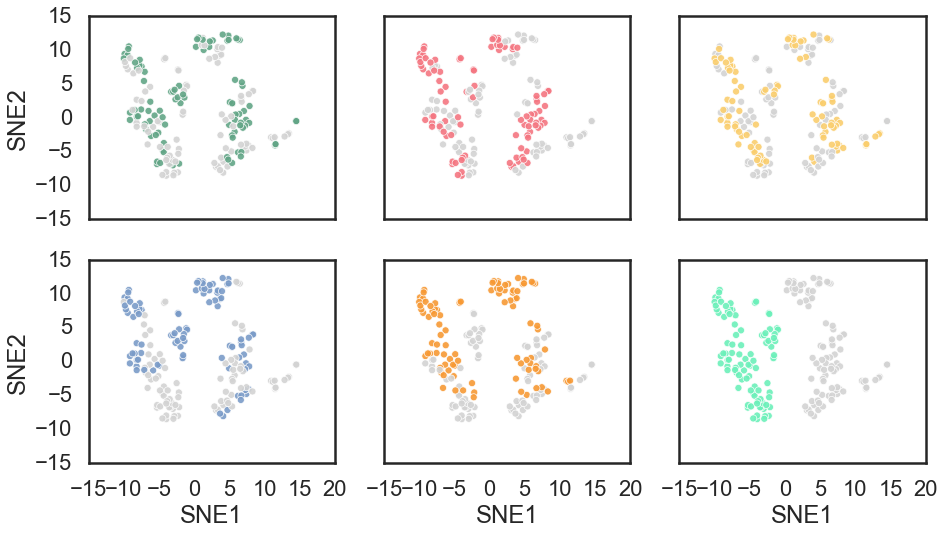

In [415]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx,i in enumerate(species):
    sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', hue=i, 
            #size='num_of_species',
            s=50, alpha=0.9, #height=5, aspect=1.2,
            legend=None, 
                    palette=[other_color, color_dict[i]],
                ax=axs[idx//3, idx%3],
                
           )

In [398]:
dfpca.columns


Index(['SNE1', 'SNE2', 'Sample', 'sample_prefix', 'MED4', '9313', '9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL'],
      dtype='object')

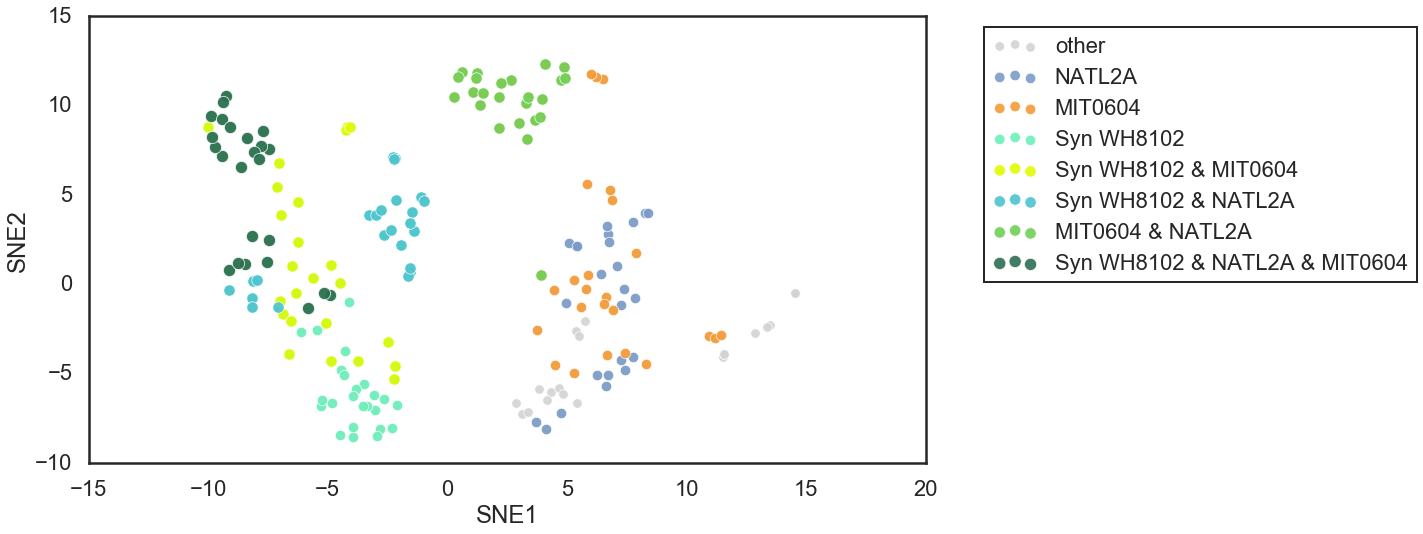

In [417]:
sns.scatterplot(data=dfpca, x='SNE1', y='SNE2', 
            s=90, alpha=0.9, #height=5, aspect=1.2,
            color=other_color, label='other')
sns.scatterplot(data=dfpca[dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=Natl2A_color, label='NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=MIT0604_color, label='MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102']], 
                x='SNE1', y='SNE2', 
            s=110, alpha=0.9, #height=5, aspect=1.2,
            color=SYN_color, label='Syn WH8102')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_0606_color, label='Syn WH8102 & MIT0604')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_color, label='Syn WH8102 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['MIT0604'] & dfpca['NATL2A']], 
                x='SNE1', y='SNE2', 
            s=130, alpha=0.9, #height=5, aspect=1.2,
            color=natl_0604_color, label='MIT0604 & NATL2A')
sns.scatterplot(data=dfpca[dfpca['Syn WH8102'] & dfpca['NATL2A'] & dfpca['MIT0604']], 
                x='SNE1', y='SNE2', 
            s=150, alpha=0.9, #height=5, aspect=1.2,
            color=syn_natl_0604_color, label='Syn WH8102 & NATL2A & MIT0604')

plt.legend(bbox_to_anchor=(1.6, 1))

In [286]:
dfpca.columns

Index(['SNE1', 'SNE2', 'Sample', 'sample_prefix', 'MED4', '9313', '9312',
       'NATL2A', 'MIT0604', 'Syn WH8102', 'num_of_species', 'ssp', 'FL'],
      dtype='object')